<a href="https://colab.research.google.com/github/katrin-ibrahim/Urban-Sound-Tagging-using-EfficientNet/blob/main/ESC50_ESC10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun  6 11:21:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


#Download Dataset

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
base_dir = "/content/drive/MyDrive"
meta_dir = base_dir + '/ESC-50/ESC-50-master/meta'
audio_dir = base_dir + '/ESC-50/ESC-50-master/audio'
augmented_audio_dir = '/content/augmented_audio'
log_dir = base_dir + "/ESC-50/data/logs"
embeddings_dir = base_dir +'/ESC-50/data/embeddings'
saved_models_dir = base_dir + '/ESC-50/data/saved_models'

In [3]:
!mkdir /content/augmented_audio

mkdir: cannot create directory ‘/content/augmented_audio’: File exists


In [4]:
# Only run first time
# !mkdir  /content/drive/MyDrive/ESC-50/data
# !mkdir /content/drive/MyDrive/ESC-50/data/saved_models
# !mkdir /content/drive/MyDrive/ESC-50/data/logs
# !mkdir /content/drive/MyDrive/ESC-50/data/embeddings

mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data/saved_models’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data/logs’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ESC-50/data/embeddings’: File exists


In [ ]:
# Only run first time to download dataset
#!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
#!unzip master.zip

In [ ]:
# Only run first time to copy dataset to drive
#!cp -r ./ESC-50-master /content/drive/MyDrive/ESC-50/

#Import Libraries

In [3]:
%%capture
!pip install autopool
!pip install audiomentations

In [30]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical


import librosa, librosa.display
import IPython
import csv
import datetime

from autopool.keras import AutoPool1D
from scipy.io.wavfile import write
from audiomentations import Compose, AddGaussianNoise, FrequencyMask, TimeStretch, PitchShift, Shift, AddBackgroundNoise

In [ ]:
print(tf.__version__)

2.8.0


#Variables

In [5]:
metadata = pd.read_csv('/content/drive/MyDrive/ESC-50/ESC-50-master/meta/esc50.csv')
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
srate = 44100 ###### 22050 --> 1104   32000 --> 800   44100*2206    BEST 44100 1024
n_fft = 1024
win_len = 1024
hop_len = 512

n_mels = 128
mono = True
# resample = 'kaiser_best'
# extraction = True #False

second = 2.5

In [18]:
epochs = 25
batch_size = 32
augmentations_arr = ['ps(-1)','ps(-2)'] 

#EDA


In [ ]:
metadata['category'].value_counts()

In [ ]:
import glob 
drive_audio_path = glob.glob(base_dir + '/ESC-50/ESC-50-master/audio/*.wav', recursive=True)
print(f"Total Audio Files : {len(drive_audio_path)}")

Total Audio Files : 2000


In [8]:
def load_sample_by_index(index):
  sample_wav = metadata.filename[index]
  sample_path = base_dir + '/ESC-50/ESC-50-master/audio'
  sample_filename = os.path.join(sample_path, sample_wav) 
  y, sr = librosa.load(sample_filename,sr=srate)
  return y,sr,sample_filename


In [9]:
def plot_sample_wave(y,path):
  plt.plot(y)
  plt.title('Signal');
  plt.xlabel('Time (samples)');
  plt.ylabel('Amplitude');

In [10]:
def plot_sample_spec(y):
  mel_spect = librosa.feature.melspectrogram(y=y, sr=srate, n_fft=n_fft, hop_length=hop_len)
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
  librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
  plt.title('Log-Mel Spectrogram');
  plt.colorbar(format='%+2.0f dB');

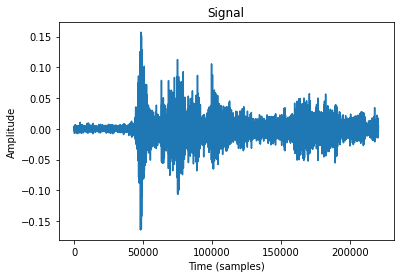

In [24]:
y,sr,path = load_sample_by_index(5)
plot_sample_wave(y,path)

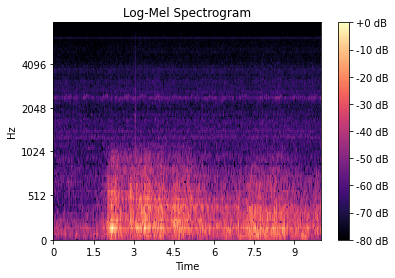

In [23]:
plot_sample_spec(y)

In [25]:
IPython.display.Audio(path)

#ESC-10 Metadata

In [11]:
# If using esc10 
metadata = metadata.loc[metadata.esc10 == True]
metadata

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,41,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,12,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,40,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,1,rooster,True,233160,A
1888,5-234879-A-1.wav,5,1,rooster,True,234879,A
1889,5-234879-B-1.wav,5,1,rooster,True,234879,B
1894,5-235671-A-38.wav,5,38,clock_tick,True,235671,A


In [32]:
metadata['category'].value_counts()

dog               40
chainsaw          40
crackling_fire    40
helicopter        40
rain              40
crying_baby       40
clock_tick        40
sneezing          40
rooster           40
sea_waves         40
Name: category, dtype: int64

#Data Augmentation
> the augmented audio will be saved to whichever directory you specify above 




In [12]:
def time_stretch(signal,sr,stretch_rate,sample_len):
  y = librosa.effects.time_stretch(signal, stretch_rate,)
  if len(y) > sample_len*sr:
    y = y[:sample_len*sr]
  elif len(y) < sample_len*sr:
    y = librosa.util.fix_length(y,sample_len*sr,mode='edge')
  return y


def pitch_shift(signal,sr,num_semitones):
  return librosa.effects.pitch_shift(signal,sr,num_semitones)

noise = Compose([
  AddGaussianNoise(min_amplitude=0.005, max_amplitude=0.15, p=1),
])
 

bg_noise = Compose([
    AddBackgroundNoise('/content/drive/MyDrive/ESC-50/data/bg_noise', 5 , 30 , 'relative' ,p=1)
])
 

In [13]:
def augmentation_helper(aug_name,y,sr):
  if aug_name == "noise":
    aug_y = noise(y,sr)

  elif aug_name == "bg":
    aug_y = bg_noise(y,sr)
    
  elif aug_name == "ps(-1)":
    aug_y = pitch_shift(y,sr,-1)

  elif aug_name == "ps(-2)":
    aug_y = pitch_shift(y,sr,-2)
  return aug_y


def apply_augmentation():
  count = 0
  for index,row in tqdm(metadata.iterrows()):
      if count%20 == 0:
        print(f"augmenting audio signal number : {count}/{len(metadata)}")
        
      
      y,sr,p = load_sample_by_index(index)
      # print(path)

      #loop over list of augmentations to apply them to all 
      for aug in augmentations_arr :
        aug_y = augmentation_helper(aug_name=aug, y=y, sr=sr)
        path = os.path.join(augmented_audio_dir,aug+"_"+ str(row["filename"]))
        print(aug,path)
        if os.path.exists(path) == False:
          write(path,sr, aug_y)
      count+=1




def get_metadata(meta_dir):
  csv_fields = ['filename', 'fold', 'target', 'category', 'src_file', 'take', 'augmented']
  count = 0
  dict_arr = []
  for index,row in tqdm(metadata.iterrows()):
    for aug in augmentations_arr :
      dict_arr.append({'filename':aug+"_"+row["filename"], 'fold':row["fold"], 'target': row["target"], 'category':row["category"], 'src_file': row["src_file"], 'take': row["take"]})
    dict_arr.append({'filename':row["filename"], 'fold':row["fold"], 'target': row["target"], 'category':row["category"], 'src_file': row["src_file"], 'take': row["take"]})


  with open(meta_dir, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = csv_fields)
    writer.writeheader()
    writer.writerows(dict_arr)


  return (pd.read_csv(meta_dir))

In [15]:
apply_augmentation()

0it [00:00, ?it/s]

augmenting audio signal number : 0/400
ps(-1) /content/augmented_audio/ps(-1)_1-100032-A-0.wav


1it [00:01,  1.57s/it]

ps(-2) /content/augmented_audio/ps(-2)_1-100032-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_1-110389-A-0.wav


2it [00:02,  1.03s/it]

ps(-2) /content/augmented_audio/ps(-2)_1-110389-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_1-116765-A-41.wav


3it [00:02,  1.14it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-116765-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_1-17150-A-12.wav


4it [00:03,  1.24it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-17150-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-172649-A-40.wav


5it [00:04,  1.32it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-172649-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-172649-B-40.wav


6it [00:05,  1.34it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-172649-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-172649-C-40.wav


7it [00:05,  1.34it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-172649-C-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-172649-D-40.wav


8it [00:06,  1.33it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-172649-D-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-172649-E-40.wav


9it [00:07,  1.35it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-172649-E-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-172649-F-40.wav


10it [00:07,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-172649-F-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-17367-A-10.wav


11it [00:08,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-17367-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_1-17565-A-12.wav


12it [00:09,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-17565-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-17742-A-12.wav


13it [00:10,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-17742-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-17808-A-12.wav


14it [00:10,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-17808-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-17808-B-12.wav


15it [00:11,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-17808-B-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-181071-A-40.wav


16it [00:12,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-181071-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-181071-B-40.wav


17it [00:12,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-181071-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_1-187207-A-20.wav


18it [00:13,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-187207-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-19898-A-41.wav


19it [00:14,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-19898-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_1-19898-B-41.wav


20it [00:14,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-19898-B-41.wav
augmenting audio signal number : 20/400
ps(-1) /content/augmented_audio/ps(-1)_1-19898-C-41.wav


21it [00:15,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-19898-C-41.wav
ps(-1) /content/augmented_audio/ps(-1)_1-211527-A-20.wav


22it [00:16,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-211527-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-211527-B-20.wav


23it [00:17,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-211527-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-211527-C-20.wav


24it [00:17,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-211527-C-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-21189-A-10.wav


25it [00:18,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-21189-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_1-21934-A-38.wav


26it [00:19,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-21934-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-21935-A-38.wav


27it [00:19,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-21935-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-22694-A-20.wav


28it [00:20,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-22694-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-22694-B-20.wav


29it [00:21,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-22694-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-26143-A-21.wav


30it [00:21,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-26143-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_1-26222-A-10.wav


31it [00:22,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-26222-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_1-26806-A-1.wav


32it [00:23,  1.46it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-26806-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-27724-A-1.wav


33it [00:23,  1.48it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-27724-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-28135-A-11.wav


34it [00:24,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-28135-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-28135-B-11.wav


35it [00:25,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-28135-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-29561-A-10.wav


36it [00:26,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-29561-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_1-29680-A-21.wav


37it [00:26,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-29680-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_1-30226-A-0.wav


38it [00:27,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-30226-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_1-30344-A-0.wav


39it [00:28,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-30344-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_1-31748-A-21.wav


40it [00:29,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-31748-A-21.wav
augmenting audio signal number : 40/400
ps(-1) /content/augmented_audio/ps(-1)_1-32318-A-0.wav


41it [00:29,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-32318-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_1-34119-A-1.wav


42it [00:30,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-34119-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-34119-B-1.wav


43it [00:31,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-34119-B-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-35687-A-38.wav


44it [00:31,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-35687-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-39901-A-11.wav


45it [00:32,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-39901-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-39901-B-11.wav


46it [00:33,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-39901-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-39923-A-1.wav


47it [00:33,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-39923-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-40730-A-1.wav


48it [00:34,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-40730-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-4211-A-12.wav


49it [00:35,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-4211-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-42139-A-38.wav


50it [00:36,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-42139-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-43382-A-1.wav


51it [00:36,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-43382-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-43760-A-11.wav


52it [00:37,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-43760-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-44831-A-1.wav


53it [00:38,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-44831-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_1-46272-A-12.wav


54it [00:39,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-46272-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-47250-A-41.wav


55it [00:39,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-47250-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_1-47250-B-41.wav


56it [00:40,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-47250-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_1-47273-A-21.wav


57it [00:41,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-47273-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_1-47274-A-21.wav


58it [00:41,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-47274-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_1-48413-A-38.wav


59it [00:42,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-48413-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-50060-A-10.wav


60it [00:43,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-50060-A-10.wav
augmenting audio signal number : 60/400
ps(-1) /content/augmented_audio/ps(-1)_1-54505-A-21.wav


61it [00:44,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-54505-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_1-54958-A-10.wav


62it [00:44,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-54958-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_1-56311-A-10.wav


63it [00:45,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-56311-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_1-57163-A-38.wav


64it [00:46,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-57163-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-59324-A-21.wav


65it [00:46,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-59324-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_1-59513-A-0.wav


66it [00:47,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-59513-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_1-60997-A-20.wav


67it [00:48,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-60997-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-60997-B-20.wav


68it [00:49,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-60997-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_1-61252-A-11.wav


69it [00:49,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-61252-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-62849-A-38.wav


70it [00:50,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-62849-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-62850-A-38.wav


71it [00:51,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-62850-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_1-63871-A-10.wav


72it [00:51,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-63871-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_1-64398-A-41.wav


73it [00:52,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-64398-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_1-64398-B-41.wav


74it [00:53,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-64398-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_1-7057-A-12.wav


75it [00:54,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-7057-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_1-81883-A-21.wav


76it [00:54,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-81883-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_1-85362-A-0.wav


77it [00:55,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-85362-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_1-91359-A-11.wav


78it [00:56,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-91359-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-91359-B-11.wav


79it [00:56,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-91359-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_1-97392-A-0.wav


80it [00:57,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_1-97392-A-0.wav
augmenting audio signal number : 80/400
ps(-1) /content/augmented_audio/ps(-1)_2-100786-A-1.wav


81it [00:58,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-100786-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_2-101676-A-10.wav


82it [00:58,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-101676-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-102852-A-11.wav


83it [00:59,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-102852-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_2-107351-A-20.wav


84it [01:00,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-107351-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_2-107351-B-20.wav


85it [01:01,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-107351-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_2-109505-A-21.wav


86it [01:01,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-109505-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-114280-A-0.wav


87it [01:02,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-114280-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-114587-A-0.wav


88it [01:03,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-114587-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-116400-A-0.wav


89it [01:04,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-116400-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-117271-A-0.wav


90it [01:04,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-117271-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-117625-A-10.wav


91it [01:05,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-117625-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-118072-A-0.wav


92it [01:06,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-118072-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-118104-A-21.wav


93it [01:06,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-118104-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-118964-A-0.wav


94it [01:07,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-118964-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-119102-A-21.wav


95it [01:08,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-119102-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-119748-A-38.wav


96it [01:08,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-119748-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-122104-A-0.wav


97it [01:09,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-122104-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-122104-B-0.wav


98it [01:10,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-122104-B-0.wav
ps(-1) /content/augmented_audio/ps(-1)_2-124662-A-11.wav


99it [01:11,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-124662-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_2-125966-A-11.wav


100it [01:11,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-125966-A-11.wav
augmenting audio signal number : 100/400
ps(-1) /content/augmented_audio/ps(-1)_2-127108-A-38.wav


101it [01:12,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-127108-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-128631-A-21.wav


102it [01:13,  1.47it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-128631-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-130978-A-21.wav


103it [01:13,  1.49it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-130978-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-130979-A-21.wav


104it [01:14,  1.48it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-130979-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-131943-A-38.wav


105it [01:15,  1.47it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-131943-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-132157-A-11.wav


106it [01:15,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-132157-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_2-132157-B-11.wav


107it [01:16,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-132157-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_2-133863-A-11.wav


108it [01:17,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-133863-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_2-134700-A-38.wav


109it [01:17,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-134700-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-135728-A-38.wav


110it [01:18,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-135728-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-137162-A-11.wav


111it [01:19,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-137162-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_2-140147-A-38.wav


112it [01:20,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-140147-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-141584-A-38.wav


113it [01:20,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-141584-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-151079-A-20.wav


114it [01:21,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-151079-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_2-155801-A-11.wav


115it [01:22,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-155801-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_2-18766-A-12.wav


116it [01:22,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-18766-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-18766-B-12.wav


117it [01:23,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-18766-B-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-188822-A-40.wav


118it [01:24,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-188822-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_2-188822-B-40.wav


119it [01:25,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-188822-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_2-188822-C-40.wav


120it [01:25,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-188822-C-40.wav
augmenting audio signal number : 120/400
ps(-1) /content/augmented_audio/ps(-1)_2-188822-D-40.wav


121it [01:26,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-188822-D-40.wav
ps(-1) /content/augmented_audio/ps(-1)_2-28314-A-12.wav


122it [01:27,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-28314-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-28314-B-12.wav


123it [01:28,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-28314-B-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-30322-A-12.wav


124it [01:28,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-30322-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-30322-B-12.wav


125it [01:29,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-30322-B-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-37806-A-40.wav


126it [01:30,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-37806-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_2-37806-B-40.wav


127it [01:31,  1.35it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-37806-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_2-37806-C-40.wav


128it [01:31,  1.35it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-37806-C-40.wav
ps(-1) /content/augmented_audio/ps(-1)_2-37806-D-40.wav


129it [01:32,  1.35it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-37806-D-40.wav
ps(-1) /content/augmented_audio/ps(-1)_2-50665-A-20.wav


130it [01:33,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-50665-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_2-50666-A-20.wav


131it [01:33,  1.35it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-50666-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_2-50667-A-41.wav


132it [01:34,  1.35it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-50667-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-50667-B-41.wav


133it [01:35,  1.33it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-50667-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-50668-A-41.wav


134it [01:36,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-50668-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-50668-B-41.wav


135it [01:36,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-50668-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-61311-A-12.wav


136it [01:37,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-61311-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-65747-A-12.wav


137it [01:38,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-65747-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_2-65750-A-1.wav


138it [01:39,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-65750-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_2-66637-A-20.wav


139it [01:39,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-66637-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_2-66637-B-20.wav


140it [01:40,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-66637-B-20.wav
augmenting audio signal number : 140/400
ps(-1) /content/augmented_audio/ps(-1)_2-68391-A-41.wav


141it [01:41,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-68391-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-68391-B-41.wav


142it [01:41,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-68391-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-71162-A-1.wav


143it [01:42,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-71162-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_2-72970-A-10.wav


144it [01:43,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-72970-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-73027-A-10.wav


145it [01:43,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-73027-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-73260-A-10.wav


146it [01:44,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-73260-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-77945-A-41.wav


147it [01:45,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-77945-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-77945-B-41.wav


148it [01:46,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-77945-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_2-80482-A-20.wav


149it [01:46,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-80482-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_2-81270-A-1.wav


150it [01:47,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-81270-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_2-81731-A-10.wav


151it [01:48,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-81731-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-82367-A-10.wav


152it [01:48,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-82367-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-82538-A-21.wav


153it [01:49,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-82538-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-87781-A-10.wav


154it [01:50,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-87781-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_2-88724-A-38.wav


155it [01:51,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-88724-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_2-93030-A-21.wav


156it [01:51,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-93030-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_2-95035-A-1.wav


157it [01:52,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-95035-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_2-95258-A-1.wav


158it [01:53,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-95258-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_2-95258-B-1.wav


159it [01:53,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-95258-B-1.wav
ps(-1) /content/augmented_audio/ps(-1)_2-96460-A-1.wav


160it [01:54,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_2-96460-A-1.wav
augmenting audio signal number : 160/400
ps(-1) /content/augmented_audio/ps(-1)_3-104632-A-12.wav


161it [01:55,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-104632-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-104958-A-12.wav


162it [01:56,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-104958-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-107219-A-1.wav


163it [01:56,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-107219-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-116135-A-1.wav


164it [01:57,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-116135-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-118656-A-41.wav


165it [01:58,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-118656-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-118657-A-41.wav


166it [01:58,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-118657-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-118657-B-41.wav


167it [01:59,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-118657-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-118658-A-41.wav


168it [02:00,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-118658-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-118658-B-41.wav


169it [02:00,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-118658-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-118972-A-41.wav


170it [02:01,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-118972-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-118972-B-41.wav


171it [02:02,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-118972-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-120644-A-12.wav


172it [02:03,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-120644-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-132852-A-10.wav


173it [02:03,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-132852-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_3-134049-A-1.wav


174it [02:04,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-134049-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-136288-A-0.wav


175it [02:05,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-136288-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_3-137152-A-1.wav


176it [02:05,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-137152-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-140774-A-10.wav


177it [02:06,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-140774-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_3-141684-A-21.wav


178it [02:07,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-141684-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-142005-A-10.wav


179it [02:07,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-142005-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_3-142006-A-10.wav


180it [02:08,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-142006-A-10.wav
augmenting audio signal number : 180/400
ps(-1) /content/augmented_audio/ps(-1)_3-142593-A-38.wav


181it [02:09,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-142593-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-142601-A-21.wav


182it [02:10,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-142601-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-142605-A-21.wav


183it [02:10,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-142605-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-143119-A-21.wav


184it [02:11,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-143119-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-143929-A-10.wav


185it [02:12,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-143929-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_3-143933-A-38.wav


186it [02:13,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-143933-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-144028-A-0.wav


187it [02:13,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-144028-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_3-144692-A-21.wav


188it [02:14,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-144692-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-144827-A-11.wav


189it [02:15,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-144827-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-144827-B-11.wav


190it [02:15,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-144827-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-145382-A-1.wav


191it [02:16,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-145382-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-145774-A-12.wav


192it [02:17,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-145774-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-147965-A-12.wav


193it [02:18,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-147965-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-148330-A-21.wav


194it [02:18,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-148330-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-149189-A-1.wav


195it [02:19,  1.46it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-149189-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-150231-A-21.wav


196it [02:20,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-150231-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-150363-A-38.wav


197it [02:20,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-150363-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-150979-A-40.wav


198it [02:21,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-150979-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_3-150979-B-40.wav


199it [02:22,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-150979-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_3-150979-C-40.wav


200it [02:23,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-150979-C-40.wav
augmenting audio signal number : 200/400
ps(-1) /content/augmented_audio/ps(-1)_3-151080-A-20.wav


201it [02:23,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-151080-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-151081-A-20.wav


202it [02:24,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-151081-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-151081-B-20.wav


203it [02:25,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-151081-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-152007-A-20.wav


204it [02:25,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-152007-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-152007-B-20.wav


205it [02:26,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-152007-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-152007-C-20.wav


206it [02:27,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-152007-C-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-152007-D-20.wav


207it [02:27,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-152007-D-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-152007-E-20.wav


208it [02:28,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-152007-E-20.wav
ps(-1) /content/augmented_audio/ps(-1)_3-154926-A-40.wav


209it [02:29,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-154926-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_3-154926-B-40.wav


210it [02:30,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-154926-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_3-154957-A-1.wav


211it [02:30,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-154957-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-155312-A-0.wav


212it [02:31,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-155312-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_3-155642-A-11.wav


213it [02:32,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-155642-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-155642-B-11.wav


214it [02:33,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-155642-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-156558-A-21.wav


215it [02:33,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-156558-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_3-157149-A-10.wav


216it [02:34,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-157149-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_3-157187-A-12.wav


217it [02:35,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-157187-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-157487-A-10.wav


218it [02:35,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-157487-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_3-157615-A-10.wav


219it [02:36,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-157615-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_3-157695-A-0.wav


220it [02:37,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-157695-A-0.wav
augmenting audio signal number : 220/400
ps(-1) /content/augmented_audio/ps(-1)_3-158476-A-12.wav


221it [02:37,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-158476-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-163288-A-1.wav


222it [02:38,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-163288-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_3-163459-A-0.wav


223it [02:39,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-163459-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_3-164120-A-11.wav


224it [02:39,  1.44it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-164120-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-164630-A-11.wav


225it [02:40,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-164630-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-164688-A-38.wav


226it [02:41,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-164688-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-165856-A-41.wav


227it [02:42,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-165856-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_3-166422-A-11.wav


228it [02:42,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-166422-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-170015-A-0.wav


229it [02:43,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-170015-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_3-170377-A-38.wav


230it [02:44,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-170377-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-170383-A-38.wav


231it [02:45,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-170383-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-171012-A-38.wav


232it [02:45,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-171012-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-171041-A-38.wav


233it [02:46,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-171041-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_3-180256-A-0.wav


234it [02:47,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-180256-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_3-180977-A-0.wav


235it [02:47,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-180977-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_3-187710-A-11.wav


236it [02:48,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-187710-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_3-65748-A-12.wav


237it [02:49,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-65748-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_3-68630-A-40.wav


238it [02:50,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-68630-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_3-68630-B-40.wav


239it [02:50,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-68630-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_3-68630-C-40.wav


240it [02:51,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_3-68630-C-40.wav
augmenting audio signal number : 240/400
ps(-1) /content/augmented_audio/ps(-1)_4-125929-A-40.wav


241it [02:52,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-125929-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_4-149294-A-41.wav


242it [02:52,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-149294-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-149294-B-41.wav


243it [02:53,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-149294-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-156843-A-21.wav


244it [02:54,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-156843-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-156844-A-21.wav


245it [02:55,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-156844-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-157297-A-21.wav


246it [02:55,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-157297-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-157611-A-41.wav


247it [02:56,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-157611-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-157611-B-41.wav


248it [02:57,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-157611-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-160999-A-10.wav


249it [02:57,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-160999-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-161127-A-10.wav


250it [02:58,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-161127-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-161579-A-40.wav


251it [02:59,  1.45it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-161579-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_4-161579-B-40.wav


252it [02:59,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-161579-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_4-163264-A-10.wav


253it [03:00,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-163264-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-164021-A-1.wav


254it [03:01,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164021-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-164064-A-1.wav


255it [03:02,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164064-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-164064-B-1.wav


256it [03:02,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164064-B-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-164064-C-1.wav


257it [03:03,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164064-C-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-164206-A-10.wav


258it [03:04,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164206-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-164661-A-12.wav


259it [03:05,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164661-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_4-164661-B-12.wav


260it [03:05,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164661-B-12.wav
augmenting audio signal number : 260/400
ps(-1) /content/augmented_audio/ps(-1)_4-164859-A-1.wav


261it [03:06,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-164859-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-165823-A-41.wav


262it [03:07,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-165823-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-165823-B-41.wav


263it [03:07,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-165823-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-166661-A-10.wav


264it [03:08,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-166661-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-167063-A-11.wav


265it [03:09,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-167063-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-167063-B-11.wav


266it [03:10,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-167063-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-167063-C-11.wav


267it [03:10,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-167063-C-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-167077-A-20.wav


268it [03:11,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-167077-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_4-167077-B-20.wav


269it [03:12,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-167077-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_4-167077-C-20.wav


270it [03:12,  1.34it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-167077-C-20.wav
ps(-1) /content/augmented_audio/ps(-1)_4-167642-A-21.wav


271it [03:13,  1.21it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-167642-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-169127-A-41.wav


272it [03:15,  1.09it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-169127-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-169127-B-41.wav


273it [03:16,  1.08it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-169127-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_4-170078-A-1.wav


274it [03:16,  1.16it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-170078-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-170247-A-12.wav


275it [03:17,  1.22it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-170247-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_4-170247-B-12.wav


276it [03:18,  1.27it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-170247-B-12.wav
ps(-1) /content/augmented_audio/ps(-1)_4-171207-A-12.wav


277it [03:18,  1.30it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-171207-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_4-171519-A-21.wav


278it [03:19,  1.33it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-171519-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-175000-A-40.wav


279it [03:21,  1.06it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-175000-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_4-175000-B-40.wav


280it [03:21,  1.08it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-175000-B-40.wav
augmenting audio signal number : 280/400
ps(-1) /content/augmented_audio/ps(-1)_4-175000-C-40.wav


281it [03:22,  1.12it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-175000-C-40.wav
ps(-1) /content/augmented_audio/ps(-1)_4-175945-A-38.wav


282it [03:23,  1.16it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-175945-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-177250-A-10.wav


283it [03:24,  1.19it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-177250-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-179984-A-38.wav


284it [03:25,  1.19it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-179984-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-180380-A-10.wav


285it [03:26,  1.15it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-180380-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-181035-A-38.wav


286it [03:26,  1.18it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-181035-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-181286-A-10.wav


287it [03:27,  1.15it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-181286-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_4-181563-A-12.wav


288it [03:28,  1.07it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-181563-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_4-181865-A-38.wav


289it [03:29,  1.11it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-181865-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-182368-A-12.wav


290it [03:30,  1.17it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-182368-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_4-182369-A-12.wav


291it [03:31,  1.24it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-182369-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_4-182395-A-0.wav


292it [03:31,  1.32it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-182395-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-182613-A-11.wav


293it [03:32,  1.34it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-182613-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-182613-B-11.wav


294it [03:33,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-182613-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-183487-A-1.wav


295it [03:33,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-183487-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-183992-A-0.wav


296it [03:34,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-183992-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-184434-A-21.wav


297it [03:35,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-184434-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-184575-A-0.wav


298it [03:36,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-184575-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-185415-A-21.wav


299it [03:36,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-185415-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-185575-A-20.wav


300it [03:37,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-185575-A-20.wav
augmenting audio signal number : 300/400
ps(-1) /content/augmented_audio/ps(-1)_4-185575-B-20.wav


301it [03:38,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-185575-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_4-185575-C-20.wav


302it [03:38,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-185575-C-20.wav
ps(-1) /content/augmented_audio/ps(-1)_4-185619-A-21.wav


303it [03:39,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-185619-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_4-188033-A-38.wav


304it [03:40,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-188033-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-191327-A-38.wav


305it [03:41,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-191327-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-191687-A-0.wav


306it [03:41,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-191687-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-192236-A-0.wav


307it [03:42,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-192236-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-193480-A-40.wav


308it [03:43,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-193480-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_4-193480-B-40.wav


309it [03:43,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-193480-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_4-194711-A-38.wav


310it [03:44,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-194711-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-194754-A-0.wav


311it [03:45,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-194754-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-195497-A-11.wav


312it [03:45,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-195497-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-195497-B-11.wav


313it [03:46,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-195497-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-198965-A-38.wav


314it [03:47,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-198965-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_4-199261-A-0.wav


315it [03:48,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-199261-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-204618-A-11.wav


316it [03:48,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-204618-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_4-207124-A-0.wav


317it [03:49,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-207124-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_4-208021-A-1.wav


318it [03:50,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-208021-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_4-59579-A-20.wav


319it [03:50,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-59579-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_4-59579-B-20.wav


320it [03:51,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_4-59579-B-20.wav
augmenting audio signal number : 320/400
ps(-1) /content/augmented_audio/ps(-1)_5-151085-A-20.wav


321it [03:52,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-151085-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-170338-A-41.wav


322it [03:53,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-170338-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-170338-B-41.wav


323it [03:53,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-170338-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-171653-A-41.wav


324it [03:54,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-171653-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-177957-A-40.wav


325it [03:55,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-177957-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-177957-B-40.wav


326it [03:55,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-177957-B-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-177957-C-40.wav


327it [03:56,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-177957-C-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-177957-D-40.wav


328it [03:57,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-177957-D-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-177957-E-40.wav


329it [03:58,  1.34it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-177957-E-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-181766-A-10.wav


330it [03:58,  1.35it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-181766-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-185579-A-41.wav


331it [03:59,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-185579-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-185579-B-41.wav


332it [04:00,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-185579-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-186924-A-12.wav


333it [04:01,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-186924-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_5-187979-A-21.wav


334it [04:01,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-187979-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-188655-A-10.wav


335it [04:02,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-188655-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-189212-A-12.wav


336it [04:03,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-189212-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_5-189237-A-12.wav


337it [04:04,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-189237-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_5-191131-A-40.wav


338it [04:04,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-191131-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-193339-A-10.wav


339it [04:05,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-193339-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-193473-A-12.wav


340it [04:06,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-193473-A-12.wav
augmenting audio signal number : 340/400
ps(-1) /content/augmented_audio/ps(-1)_5-193473-B-12.wav


341it [04:06,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-193473-B-12.wav
ps(-1) /content/augmented_audio/ps(-1)_5-194533-A-21.wav


342it [04:07,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-194533-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-194892-A-10.wav


343it [04:08,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-194892-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-194930-A-1.wav


344it [04:09,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-194930-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-194930-B-1.wav


345it [04:09,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-194930-B-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-195710-A-10.wav


346it [04:10,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-195710-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198321-A-10.wav


347it [04:11,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198321-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198411-A-20.wav


348it [04:11,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198411-A-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198411-B-20.wav


349it [04:12,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198411-B-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198411-C-20.wav


350it [04:13,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198411-C-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198411-D-20.wav


351it [04:14,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198411-D-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198411-E-20.wav


352it [04:14,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198411-E-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198411-F-20.wav


353it [04:15,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198411-F-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-198411-G-20.wav


354it [04:16,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-198411-G-20.wav
ps(-1) /content/augmented_audio/ps(-1)_5-200334-A-1.wav


355it [04:16,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-200334-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-200334-B-1.wav


356it [04:17,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-200334-B-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-200339-A-1.wav


357it [04:18,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-200339-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-200461-A-11.wav


358it [04:19,  1.36it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-200461-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-200461-B-11.wav


359it [04:19,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-200461-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-201194-A-38.wav


360it [04:20,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-201194-A-38.wav
augmenting audio signal number : 360/400
ps(-1) /content/augmented_audio/ps(-1)_5-201274-A-21.wav


361it [04:21,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-201274-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-202220-A-21.wav


362it [04:22,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-202220-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-202898-A-10.wav


363it [04:22,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-202898-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-203128-A-0.wav


364it [04:23,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-203128-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_5-203128-B-0.wav


365it [04:24,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-203128-B-0.wav
ps(-1) /content/augmented_audio/ps(-1)_5-203739-A-10.wav


366it [04:24,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-203739-A-10.wav
ps(-1) /content/augmented_audio/ps(-1)_5-205898-A-40.wav


367it [04:25,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-205898-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-208030-A-0.wav


368it [04:26,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-208030-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_5-208624-A-38.wav


369it [04:27,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-208624-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_5-208810-A-11.wav


370it [04:27,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-208810-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-208810-B-11.wav


371it [04:28,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-208810-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-209698-A-38.wav


372it [04:29,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-209698-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_5-209833-A-38.wav


373it [04:29,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-209833-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_5-210571-A-38.wav


374it [04:30,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-210571-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_5-212181-A-38.wav


375it [04:31,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-212181-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_5-212454-A-0.wav


376it [04:32,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-212454-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_5-213077-A-11.wav


377it [04:32,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-213077-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-213802-A-12.wav


378it [04:33,  1.39it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-213802-A-12.wav
ps(-1) /content/augmented_audio/ps(-1)_5-213855-A-0.wav


379it [04:34,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-213855-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_5-215658-A-12.wav


380it [04:34,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-215658-A-12.wav
augmenting audio signal number : 380/400
ps(-1) /content/augmented_audio/ps(-1)_5-215658-B-12.wav


381it [04:35,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-215658-B-12.wav
ps(-1) /content/augmented_audio/ps(-1)_5-216370-A-41.wav


382it [04:36,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-216370-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-216370-B-41.wav


383it [04:37,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-216370-B-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-217158-A-0.wav


384it [04:37,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-217158-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_5-219342-A-38.wav


385it [04:38,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-219342-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_5-219379-A-11.wav


386it [04:39,  1.40it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-219379-A-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-219379-B-11.wav


387it [04:39,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-219379-B-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-219379-C-11.wav


388it [04:40,  1.34it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-219379-C-11.wav
ps(-1) /content/augmented_audio/ps(-1)_5-220026-A-21.wav


389it [04:41,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-220026-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-220027-A-21.wav


390it [04:42,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-220027-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-220955-A-40.wav


391it [04:42,  1.37it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-220955-A-40.wav
ps(-1) /content/augmented_audio/ps(-1)_5-221518-A-21.wav


392it [04:43,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-221518-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-221593-A-21.wav


393it [04:44,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-221593-A-21.wav
ps(-1) /content/augmented_audio/ps(-1)_5-222524-A-41.wav


394it [04:44,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-222524-A-41.wav
ps(-1) /content/augmented_audio/ps(-1)_5-231762-A-0.wav


395it [04:45,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-231762-A-0.wav
ps(-1) /content/augmented_audio/ps(-1)_5-233160-A-1.wav


396it [04:46,  1.41it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-233160-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-234879-A-1.wav


397it [04:47,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-234879-A-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-234879-B-1.wav


398it [04:47,  1.43it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-234879-B-1.wav
ps(-1) /content/augmented_audio/ps(-1)_5-235671-A-38.wav


399it [04:48,  1.42it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-235671-A-38.wav
ps(-1) /content/augmented_audio/ps(-1)_5-9032-A-0.wav


400it [04:49,  1.38it/s]

ps(-2) /content/augmented_audio/ps(-2)_5-9032-A-0.wav


##Get Augmented Metadata

In [14]:
metadata_aug = get_metadata("aug.csv") 
len(metadata_aug)

400it [00:00, 9056.43it/s]


1200

##Visualise Augmentations

In [ ]:
y,sr

#Feature Extraction
> the following will extract feature embeddings which will be saved to whichever directory you specify above 

In [16]:
def feature_extractor(filename, srate=srate):

    if filename[0].isdigit() == True :
        file_name = os.path.join(audio_dir, filename)
    else :
        file_name = os.path.join(augmented_audio_dir, filename) 
  
    try:
        y, sr = librosa.load(file_name, sr=srate, mono=mono)
    except:
        raise IOError('Give me an audio  file which I can read!!')

    feature_data = []

    for i in range(2):
      i = i*int(srate*second)

      if i+ int(srate*second)>srate*10:
        break
    
      split_y = y[i : i + int(srate*second)]
      inpt = librosa.power_to_db(librosa.feature.melspectrogram(y=split_y, sr=srate, n_fft=n_fft, hop_length=hop_len, win_length=win_len, n_mels=n_mels))
      
      inpt = np.array(inpt)
      stack_inpt = np.stack(([inpt], [inpt], [inpt]), axis=3)
      feature = np.reshape(stack_inpt, (stack_inpt.shape[1], stack_inpt.shape[2], stack_inpt.shape[3]))
      feature_data.append(feature)
      
    feature_data = np.asarray(feature_data)
    return feature_data

In [19]:
for index, row in tqdm(metadata_aug.iterrows()):
  
    filename = row["filename"]
    path = os.path.join(embeddings_dir,filename+".npy")
   
    if os.path.exists(path) == False:
      feature = feature_extractor(filename)
      x = np.array(feature)
      np.save(os.path.join(embeddings_dir,filename),x)
      print(f"extraction file: {filename} in index: {index}/{len(metadata)}")
    else:
      print(f'already extracted features for sample in index: {index}')

6it [00:00, 24.48it/s]

extraction file: ps(-1)_1-100032-A-0.wav in index: 0/400
extraction file: ps(-2)_1-100032-A-0.wav in index: 1/400
extraction file: 1-100032-A-0.wav in index: 2/400
extraction file: ps(-1)_1-110389-A-0.wav in index: 3/400
extraction file: ps(-2)_1-110389-A-0.wav in index: 4/400
extraction file: 1-110389-A-0.wav in index: 5/400


12it [00:00, 25.71it/s]

extraction file: ps(-1)_1-116765-A-41.wav in index: 6/400
extraction file: ps(-2)_1-116765-A-41.wav in index: 7/400
extraction file: 1-116765-A-41.wav in index: 8/400
extraction file: ps(-1)_1-17150-A-12.wav in index: 9/400
extraction file: ps(-2)_1-17150-A-12.wav in index: 10/400
extraction file: 1-17150-A-12.wav in index: 11/400


15it [00:00, 24.14it/s]

extraction file: ps(-1)_1-172649-A-40.wav in index: 12/400
extraction file: ps(-2)_1-172649-A-40.wav in index: 13/400
extraction file: 1-172649-A-40.wav in index: 14/400
extraction file: ps(-1)_1-172649-B-40.wav in index: 15/400
extraction file: ps(-2)_1-172649-B-40.wav in index: 16/400


21it [00:00, 21.51it/s]

extraction file: 1-172649-B-40.wav in index: 17/400
extraction file: ps(-1)_1-172649-C-40.wav in index: 18/400
extraction file: ps(-2)_1-172649-C-40.wav in index: 19/400
extraction file: 1-172649-C-40.wav in index: 20/400


24it [00:01, 20.55it/s]

extraction file: ps(-1)_1-172649-D-40.wav in index: 21/400
extraction file: ps(-2)_1-172649-D-40.wav in index: 22/400
extraction file: 1-172649-D-40.wav in index: 23/400
extraction file: ps(-1)_1-172649-E-40.wav in index: 24/400
extraction file: ps(-2)_1-172649-E-40.wav in index: 25/400


30it [00:01, 19.66it/s]

extraction file: 1-172649-E-40.wav in index: 26/400
extraction file: ps(-1)_1-172649-F-40.wav in index: 27/400
extraction file: ps(-2)_1-172649-F-40.wav in index: 28/400
extraction file: 1-172649-F-40.wav in index: 29/400


32it [00:01, 19.41it/s]

extraction file: ps(-1)_1-17367-A-10.wav in index: 30/400
extraction file: ps(-2)_1-17367-A-10.wav in index: 31/400
extraction file: 1-17367-A-10.wav in index: 32/400
extraction file: ps(-1)_1-17565-A-12.wav in index: 33/400


37it [00:01, 19.02it/s]

extraction file: ps(-2)_1-17565-A-12.wav in index: 34/400
extraction file: 1-17565-A-12.wav in index: 35/400
extraction file: ps(-1)_1-17742-A-12.wav in index: 36/400
extraction file: ps(-2)_1-17742-A-12.wav in index: 37/400


41it [00:01, 18.58it/s]

extraction file: 1-17742-A-12.wav in index: 38/400
extraction file: ps(-1)_1-17808-A-12.wav in index: 39/400
extraction file: ps(-2)_1-17808-A-12.wav in index: 40/400
extraction file: 1-17808-A-12.wav in index: 41/400


45it [00:02, 18.97it/s]

extraction file: ps(-1)_1-17808-B-12.wav in index: 42/400
extraction file: ps(-2)_1-17808-B-12.wav in index: 43/400
extraction file: 1-17808-B-12.wav in index: 44/400
extraction file: ps(-1)_1-181071-A-40.wav in index: 45/400


49it [00:02, 17.39it/s]

extraction file: ps(-2)_1-181071-A-40.wav in index: 46/400
extraction file: 1-181071-A-40.wav in index: 47/400
extraction file: ps(-1)_1-181071-B-40.wav in index: 48/400
extraction file: ps(-2)_1-181071-B-40.wav in index: 49/400


53it [00:02, 17.17it/s]

extraction file: 1-181071-B-40.wav in index: 50/400
extraction file: ps(-1)_1-187207-A-20.wav in index: 51/400
extraction file: ps(-2)_1-187207-A-20.wav in index: 52/400
extraction file: 1-187207-A-20.wav in index: 53/400


57it [00:02, 17.88it/s]

extraction file: ps(-1)_1-19898-A-41.wav in index: 54/400
extraction file: ps(-2)_1-19898-A-41.wav in index: 55/400
extraction file: 1-19898-A-41.wav in index: 56/400
extraction file: ps(-1)_1-19898-B-41.wav in index: 57/400


61it [00:03, 18.29it/s]

extraction file: ps(-2)_1-19898-B-41.wav in index: 58/400
extraction file: 1-19898-B-41.wav in index: 59/400
extraction file: ps(-1)_1-19898-C-41.wav in index: 60/400
extraction file: ps(-2)_1-19898-C-41.wav in index: 61/400


65it [00:03, 18.98it/s]

extraction file: 1-19898-C-41.wav in index: 62/400
extraction file: ps(-1)_1-211527-A-20.wav in index: 63/400
extraction file: ps(-2)_1-211527-A-20.wav in index: 64/400
extraction file: 1-211527-A-20.wav in index: 65/400


69it [00:03, 18.13it/s]

extraction file: ps(-1)_1-211527-B-20.wav in index: 66/400
extraction file: ps(-2)_1-211527-B-20.wav in index: 67/400
extraction file: 1-211527-B-20.wav in index: 68/400
extraction file: ps(-1)_1-211527-C-20.wav in index: 69/400


74it [00:03, 19.11it/s]

extraction file: ps(-2)_1-211527-C-20.wav in index: 70/400
extraction file: 1-211527-C-20.wav in index: 71/400
extraction file: ps(-1)_1-21189-A-10.wav in index: 72/400
extraction file: ps(-2)_1-21189-A-10.wav in index: 73/400


79it [00:04, 20.02it/s]

extraction file: 1-21189-A-10.wav in index: 74/400
extraction file: ps(-1)_1-21934-A-38.wav in index: 75/400
extraction file: ps(-2)_1-21934-A-38.wav in index: 76/400
extraction file: 1-21934-A-38.wav in index: 77/400
extraction file: ps(-1)_1-21935-A-38.wav in index: 78/400


82it [00:04, 21.08it/s]

extraction file: ps(-2)_1-21935-A-38.wav in index: 79/400
extraction file: 1-21935-A-38.wav in index: 80/400
extraction file: ps(-1)_1-22694-A-20.wav in index: 81/400
extraction file: ps(-2)_1-22694-A-20.wav in index: 82/400
extraction file: 1-22694-A-20.wav in index: 83/400


88it [00:04, 20.39it/s]

extraction file: ps(-1)_1-22694-B-20.wav in index: 84/400
extraction file: ps(-2)_1-22694-B-20.wav in index: 85/400
extraction file: 1-22694-B-20.wav in index: 86/400
extraction file: ps(-1)_1-26143-A-21.wav in index: 87/400


91it [00:04, 20.82it/s]

extraction file: ps(-2)_1-26143-A-21.wav in index: 88/400
extraction file: 1-26143-A-21.wav in index: 89/400
extraction file: ps(-1)_1-26222-A-10.wav in index: 90/400
extraction file: ps(-2)_1-26222-A-10.wav in index: 91/400
extraction file: 1-26222-A-10.wav in index: 92/400


97it [00:04, 22.26it/s]

extraction file: ps(-1)_1-26806-A-1.wav in index: 93/400
extraction file: ps(-2)_1-26806-A-1.wav in index: 94/400
extraction file: 1-26806-A-1.wav in index: 95/400
extraction file: ps(-1)_1-27724-A-1.wav in index: 96/400
extraction file: ps(-2)_1-27724-A-1.wav in index: 97/400


103it [00:05, 22.49it/s]

extraction file: 1-27724-A-1.wav in index: 98/400
extraction file: ps(-1)_1-28135-A-11.wav in index: 99/400
extraction file: ps(-2)_1-28135-A-11.wav in index: 100/400
extraction file: 1-28135-A-11.wav in index: 101/400
extraction file: ps(-1)_1-28135-B-11.wav in index: 102/400


106it [00:05, 21.58it/s]

extraction file: ps(-2)_1-28135-B-11.wav in index: 103/400
extraction file: 1-28135-B-11.wav in index: 104/400
extraction file: ps(-1)_1-29561-A-10.wav in index: 105/400
extraction file: ps(-2)_1-29561-A-10.wav in index: 106/400
extraction file: 1-29561-A-10.wav in index: 107/400


112it [00:05, 22.55it/s]

extraction file: ps(-1)_1-29680-A-21.wav in index: 108/400
extraction file: ps(-2)_1-29680-A-21.wav in index: 109/400
extraction file: 1-29680-A-21.wav in index: 110/400
extraction file: ps(-1)_1-30226-A-0.wav in index: 111/400
extraction file: ps(-2)_1-30226-A-0.wav in index: 112/400


118it [00:05, 23.67it/s]

extraction file: 1-30226-A-0.wav in index: 113/400
extraction file: ps(-1)_1-30344-A-0.wav in index: 114/400
extraction file: ps(-2)_1-30344-A-0.wav in index: 115/400
extraction file: 1-30344-A-0.wav in index: 116/400
extraction file: ps(-1)_1-31748-A-21.wav in index: 117/400


121it [00:05, 23.52it/s]

extraction file: ps(-2)_1-31748-A-21.wav in index: 118/400
extraction file: 1-31748-A-21.wav in index: 119/400
extraction file: ps(-1)_1-32318-A-0.wav in index: 120/400
extraction file: ps(-2)_1-32318-A-0.wav in index: 121/400
extraction file: 1-32318-A-0.wav in index: 122/400


126it [00:06, 13.85it/s]

extraction file: ps(-1)_1-34119-A-1.wav in index: 123/400
extraction file: ps(-2)_1-34119-A-1.wav in index: 124/400
extraction file: 1-34119-A-1.wav in index: 125/400
extraction file: ps(-1)_1-34119-B-1.wav in index: 126/400


131it [00:06, 16.46it/s]

extraction file: ps(-2)_1-34119-B-1.wav in index: 127/400
extraction file: 1-34119-B-1.wav in index: 128/400
extraction file: ps(-1)_1-35687-A-38.wav in index: 129/400
extraction file: ps(-2)_1-35687-A-38.wav in index: 130/400
extraction file: 1-35687-A-38.wav in index: 131/400


135it [00:06, 17.66it/s]

extraction file: ps(-1)_1-39901-A-11.wav in index: 132/400
extraction file: ps(-2)_1-39901-A-11.wav in index: 133/400
extraction file: 1-39901-A-11.wav in index: 134/400
extraction file: ps(-1)_1-39901-B-11.wav in index: 135/400


140it [00:07, 18.68it/s]

extraction file: ps(-2)_1-39901-B-11.wav in index: 136/400
extraction file: 1-39901-B-11.wav in index: 137/400
extraction file: ps(-1)_1-39923-A-1.wav in index: 138/400
extraction file: ps(-2)_1-39923-A-1.wav in index: 139/400


144it [00:07, 18.24it/s]

extraction file: 1-39923-A-1.wav in index: 140/400
extraction file: ps(-1)_1-40730-A-1.wav in index: 141/400
extraction file: ps(-2)_1-40730-A-1.wav in index: 142/400
extraction file: 1-40730-A-1.wav in index: 143/400
extraction file: ps(-1)_1-4211-A-12.wav in index: 144/400


149it [00:07, 19.14it/s]

extraction file: ps(-2)_1-4211-A-12.wav in index: 145/400
extraction file: 1-4211-A-12.wav in index: 146/400
extraction file: ps(-1)_1-42139-A-38.wav in index: 147/400
extraction file: ps(-2)_1-42139-A-38.wav in index: 148/400
extraction file: 1-42139-A-38.wav in index: 149/400


153it [00:07, 19.36it/s]

extraction file: ps(-1)_1-43382-A-1.wav in index: 150/400
extraction file: ps(-2)_1-43382-A-1.wav in index: 151/400
extraction file: 1-43382-A-1.wav in index: 152/400
extraction file: ps(-1)_1-43760-A-11.wav in index: 153/400
extraction file: ps(-2)_1-43760-A-11.wav in index: 154/400


159it [00:08, 20.57it/s]

extraction file: 1-43760-A-11.wav in index: 155/400
extraction file: ps(-1)_1-44831-A-1.wav in index: 156/400
extraction file: ps(-2)_1-44831-A-1.wav in index: 157/400
extraction file: 1-44831-A-1.wav in index: 158/400
extraction file: ps(-1)_1-46272-A-12.wav in index: 159/400


165it [00:08, 22.64it/s]

extraction file: ps(-2)_1-46272-A-12.wav in index: 160/400
extraction file: 1-46272-A-12.wav in index: 161/400
extraction file: ps(-1)_1-47250-A-41.wav in index: 162/400
extraction file: ps(-2)_1-47250-A-41.wav in index: 163/400
extraction file: 1-47250-A-41.wav in index: 164/400


168it [00:08, 21.39it/s]

extraction file: ps(-1)_1-47250-B-41.wav in index: 165/400
extraction file: ps(-2)_1-47250-B-41.wav in index: 166/400
extraction file: 1-47250-B-41.wav in index: 167/400
extraction file: ps(-1)_1-47273-A-21.wav in index: 168/400
extraction file: ps(-2)_1-47273-A-21.wav in index: 169/400


174it [00:08, 23.13it/s]

extraction file: 1-47273-A-21.wav in index: 170/400
extraction file: ps(-1)_1-47274-A-21.wav in index: 171/400
extraction file: ps(-2)_1-47274-A-21.wav in index: 172/400
extraction file: 1-47274-A-21.wav in index: 173/400
extraction file: ps(-1)_1-48413-A-38.wav in index: 174/400


180it [00:09, 22.29it/s]

extraction file: ps(-2)_1-48413-A-38.wav in index: 175/400
extraction file: 1-48413-A-38.wav in index: 176/400
extraction file: ps(-1)_1-50060-A-10.wav in index: 177/400
extraction file: ps(-2)_1-50060-A-10.wav in index: 178/400
extraction file: 1-50060-A-10.wav in index: 179/400


186it [00:09, 23.92it/s]

extraction file: ps(-1)_1-54505-A-21.wav in index: 180/400
extraction file: ps(-2)_1-54505-A-21.wav in index: 181/400
extraction file: 1-54505-A-21.wav in index: 182/400
extraction file: ps(-1)_1-54958-A-10.wav in index: 183/400
extraction file: ps(-2)_1-54958-A-10.wav in index: 184/400
extraction file: 1-54958-A-10.wav in index: 185/400


192it [00:09, 24.50it/s]

extraction file: ps(-1)_1-56311-A-10.wav in index: 186/400
extraction file: ps(-2)_1-56311-A-10.wav in index: 187/400
extraction file: 1-56311-A-10.wav in index: 188/400
extraction file: ps(-1)_1-57163-A-38.wav in index: 189/400
extraction file: ps(-2)_1-57163-A-38.wav in index: 190/400
extraction file: 1-57163-A-38.wav in index: 191/400


195it [00:09, 22.40it/s]

extraction file: ps(-1)_1-59324-A-21.wav in index: 192/400
extraction file: ps(-2)_1-59324-A-21.wav in index: 193/400
extraction file: 1-59324-A-21.wav in index: 194/400
extraction file: ps(-1)_1-59513-A-0.wav in index: 195/400
extraction file: ps(-2)_1-59513-A-0.wav in index: 196/400


201it [00:09, 23.97it/s]

extraction file: 1-59513-A-0.wav in index: 197/400
extraction file: ps(-1)_1-60997-A-20.wav in index: 198/400
extraction file: ps(-2)_1-60997-A-20.wav in index: 199/400
extraction file: 1-60997-A-20.wav in index: 200/400
extraction file: ps(-1)_1-60997-B-20.wav in index: 201/400
extraction file: ps(-2)_1-60997-B-20.wav in index: 202/400


204it [00:10, 22.19it/s]

extraction file: 1-60997-B-20.wav in index: 203/400
extraction file: ps(-1)_1-61252-A-11.wav in index: 204/400


207it [00:10, 15.97it/s]

extraction file: ps(-2)_1-61252-A-11.wav in index: 205/400
extraction file: 1-61252-A-11.wav in index: 206/400


209it [00:10, 13.57it/s]

extraction file: ps(-1)_1-62849-A-38.wav in index: 207/400
extraction file: ps(-2)_1-62849-A-38.wav in index: 208/400


214it [00:10, 16.16it/s]

extraction file: 1-62849-A-38.wav in index: 209/400
extraction file: ps(-1)_1-62850-A-38.wav in index: 210/400
extraction file: ps(-2)_1-62850-A-38.wav in index: 211/400
extraction file: 1-62850-A-38.wav in index: 212/400
extraction file: ps(-1)_1-63871-A-10.wav in index: 213/400


219it [00:11, 18.86it/s]

extraction file: ps(-2)_1-63871-A-10.wav in index: 214/400
extraction file: 1-63871-A-10.wav in index: 215/400
extraction file: ps(-1)_1-64398-A-41.wav in index: 216/400
extraction file: ps(-2)_1-64398-A-41.wav in index: 217/400
extraction file: 1-64398-A-41.wav in index: 218/400


225it [00:11, 19.26it/s]

extraction file: ps(-1)_1-64398-B-41.wav in index: 219/400
extraction file: ps(-2)_1-64398-B-41.wav in index: 220/400
extraction file: 1-64398-B-41.wav in index: 221/400
extraction file: ps(-1)_1-7057-A-12.wav in index: 222/400
extraction file: ps(-2)_1-7057-A-12.wav in index: 223/400
extraction file: 1-7057-A-12.wav in index: 224/400


228it [00:11, 17.04it/s]

extraction file: ps(-1)_1-81883-A-21.wav in index: 225/400
extraction file: ps(-2)_1-81883-A-21.wav in index: 226/400
extraction file: 1-81883-A-21.wav in index: 227/400
extraction file: ps(-1)_1-85362-A-0.wav in index: 228/400
extraction file: ps(-2)_1-85362-A-0.wav in index: 229/400


234it [00:11, 19.43it/s]

extraction file: 1-85362-A-0.wav in index: 230/400
extraction file: ps(-1)_1-91359-A-11.wav in index: 231/400
extraction file: ps(-2)_1-91359-A-11.wav in index: 232/400
extraction file: 1-91359-A-11.wav in index: 233/400
extraction file: ps(-1)_1-91359-B-11.wav in index: 234/400


240it [00:12, 21.00it/s]

extraction file: ps(-2)_1-91359-B-11.wav in index: 235/400
extraction file: 1-91359-B-11.wav in index: 236/400
extraction file: ps(-1)_1-97392-A-0.wav in index: 237/400
extraction file: ps(-2)_1-97392-A-0.wav in index: 238/400
extraction file: 1-97392-A-0.wav in index: 239/400


243it [00:12, 20.66it/s]

extraction file: ps(-1)_2-100786-A-1.wav in index: 240/400
extraction file: ps(-2)_2-100786-A-1.wav in index: 241/400
extraction file: 2-100786-A-1.wav in index: 242/400
extraction file: ps(-1)_2-101676-A-10.wav in index: 243/400
extraction file: ps(-2)_2-101676-A-10.wav in index: 244/400


249it [00:12, 20.71it/s]

extraction file: 2-101676-A-10.wav in index: 245/400
extraction file: ps(-1)_2-102852-A-11.wav in index: 246/400
extraction file: ps(-2)_2-102852-A-11.wav in index: 247/400
extraction file: 2-102852-A-11.wav in index: 248/400
extraction file: ps(-1)_2-107351-A-20.wav in index: 249/400


255it [00:12, 20.18it/s]

extraction file: ps(-2)_2-107351-A-20.wav in index: 250/400
extraction file: 2-107351-A-20.wav in index: 251/400
extraction file: ps(-1)_2-107351-B-20.wav in index: 252/400
extraction file: ps(-2)_2-107351-B-20.wav in index: 253/400
extraction file: 2-107351-B-20.wav in index: 254/400


258it [00:13, 20.39it/s]

extraction file: ps(-1)_2-109505-A-21.wav in index: 255/400
extraction file: ps(-2)_2-109505-A-21.wav in index: 256/400
extraction file: 2-109505-A-21.wav in index: 257/400
extraction file: ps(-1)_2-114280-A-0.wav in index: 258/400
extraction file: ps(-2)_2-114280-A-0.wav in index: 259/400


264it [00:13, 20.29it/s]

extraction file: 2-114280-A-0.wav in index: 260/400
extraction file: ps(-1)_2-114587-A-0.wav in index: 261/400
extraction file: ps(-2)_2-114587-A-0.wav in index: 262/400
extraction file: 2-114587-A-0.wav in index: 263/400


267it [00:13, 21.26it/s]

extraction file: ps(-1)_2-116400-A-0.wav in index: 264/400
extraction file: ps(-2)_2-116400-A-0.wav in index: 265/400
extraction file: 2-116400-A-0.wav in index: 266/400
extraction file: ps(-1)_2-117271-A-0.wav in index: 267/400
extraction file: ps(-2)_2-117271-A-0.wav in index: 268/400


273it [00:13, 21.96it/s]

extraction file: 2-117271-A-0.wav in index: 269/400
extraction file: ps(-1)_2-117625-A-10.wav in index: 270/400
extraction file: ps(-2)_2-117625-A-10.wav in index: 271/400
extraction file: 2-117625-A-10.wav in index: 272/400
extraction file: ps(-1)_2-118072-A-0.wav in index: 273/400


279it [00:14, 21.44it/s]

extraction file: ps(-2)_2-118072-A-0.wav in index: 274/400
extraction file: 2-118072-A-0.wav in index: 275/400
extraction file: ps(-1)_2-118104-A-21.wav in index: 276/400
extraction file: ps(-2)_2-118104-A-21.wav in index: 277/400
extraction file: 2-118104-A-21.wav in index: 278/400


282it [00:14, 21.26it/s]

extraction file: ps(-1)_2-118964-A-0.wav in index: 279/400
extraction file: ps(-2)_2-118964-A-0.wav in index: 280/400
extraction file: 2-118964-A-0.wav in index: 281/400
extraction file: ps(-1)_2-119102-A-21.wav in index: 282/400
extraction file: ps(-2)_2-119102-A-21.wav in index: 283/400


288it [00:14, 22.23it/s]

extraction file: 2-119102-A-21.wav in index: 284/400
extraction file: ps(-1)_2-119748-A-38.wav in index: 285/400
extraction file: ps(-2)_2-119748-A-38.wav in index: 286/400
extraction file: 2-119748-A-38.wav in index: 287/400
extraction file: ps(-1)_2-122104-A-0.wav in index: 288/400


294it [00:14, 23.08it/s]

extraction file: ps(-2)_2-122104-A-0.wav in index: 289/400
extraction file: 2-122104-A-0.wav in index: 290/400
extraction file: ps(-1)_2-122104-B-0.wav in index: 291/400
extraction file: ps(-2)_2-122104-B-0.wav in index: 292/400
extraction file: 2-122104-B-0.wav in index: 293/400
extraction file: ps(-1)_2-124662-A-11.wav in index: 294/400
extraction file: ps(-2)_2-124662-A-11.wav in index: 295/400


299it [00:15,  9.72it/s]

extraction file: 2-124662-A-11.wav in index: 296/400
extraction file: ps(-1)_2-125966-A-11.wav in index: 297/400
extraction file: ps(-2)_2-125966-A-11.wav in index: 298/400


304it [00:15, 13.07it/s]

extraction file: 2-125966-A-11.wav in index: 299/400
extraction file: ps(-1)_2-127108-A-38.wav in index: 300/400
extraction file: ps(-2)_2-127108-A-38.wav in index: 301/400
extraction file: 2-127108-A-38.wav in index: 302/400
extraction file: ps(-1)_2-128631-A-21.wav in index: 303/400


307it [00:16, 15.15it/s]

extraction file: ps(-2)_2-128631-A-21.wav in index: 304/400
extraction file: 2-128631-A-21.wav in index: 305/400
extraction file: ps(-1)_2-130978-A-21.wav in index: 306/400
extraction file: ps(-2)_2-130978-A-21.wav in index: 307/400
extraction file: 2-130978-A-21.wav in index: 308/400


313it [00:16, 18.82it/s]

extraction file: ps(-1)_2-130979-A-21.wav in index: 309/400
extraction file: ps(-2)_2-130979-A-21.wav in index: 310/400
extraction file: 2-130979-A-21.wav in index: 311/400
extraction file: ps(-1)_2-131943-A-38.wav in index: 312/400
extraction file: ps(-2)_2-131943-A-38.wav in index: 313/400


319it [00:16, 20.29it/s]

extraction file: 2-131943-A-38.wav in index: 314/400
extraction file: ps(-1)_2-132157-A-11.wav in index: 315/400
extraction file: ps(-2)_2-132157-A-11.wav in index: 316/400
extraction file: 2-132157-A-11.wav in index: 317/400
extraction file: ps(-1)_2-132157-B-11.wav in index: 318/400


322it [00:16, 20.52it/s]

extraction file: ps(-2)_2-132157-B-11.wav in index: 319/400
extraction file: 2-132157-B-11.wav in index: 320/400
extraction file: ps(-1)_2-133863-A-11.wav in index: 321/400
extraction file: ps(-2)_2-133863-A-11.wav in index: 322/400
extraction file: 2-133863-A-11.wav in index: 323/400


328it [00:17, 21.51it/s]

extraction file: ps(-1)_2-134700-A-38.wav in index: 324/400
extraction file: ps(-2)_2-134700-A-38.wav in index: 325/400
extraction file: 2-134700-A-38.wav in index: 326/400
extraction file: ps(-1)_2-135728-A-38.wav in index: 327/400
extraction file: ps(-2)_2-135728-A-38.wav in index: 328/400


334it [00:17, 22.04it/s]

extraction file: 2-135728-A-38.wav in index: 329/400
extraction file: ps(-1)_2-137162-A-11.wav in index: 330/400
extraction file: ps(-2)_2-137162-A-11.wav in index: 331/400
extraction file: 2-137162-A-11.wav in index: 332/400
extraction file: ps(-1)_2-140147-A-38.wav in index: 333/400


337it [00:17, 22.78it/s]

extraction file: ps(-2)_2-140147-A-38.wav in index: 334/400
extraction file: 2-140147-A-38.wav in index: 335/400
extraction file: ps(-1)_2-141584-A-38.wav in index: 336/400
extraction file: ps(-2)_2-141584-A-38.wav in index: 337/400
extraction file: 2-141584-A-38.wav in index: 338/400


343it [00:17, 22.96it/s]

extraction file: ps(-1)_2-151079-A-20.wav in index: 339/400
extraction file: ps(-2)_2-151079-A-20.wav in index: 340/400
extraction file: 2-151079-A-20.wav in index: 341/400
extraction file: ps(-1)_2-155801-A-11.wav in index: 342/400
extraction file: ps(-2)_2-155801-A-11.wav in index: 343/400


349it [00:17, 21.55it/s]

extraction file: 2-155801-A-11.wav in index: 344/400
extraction file: ps(-1)_2-18766-A-12.wav in index: 345/400
extraction file: ps(-2)_2-18766-A-12.wav in index: 346/400
extraction file: 2-18766-A-12.wav in index: 347/400
extraction file: ps(-1)_2-18766-B-12.wav in index: 348/400


352it [00:18, 21.52it/s]

extraction file: ps(-2)_2-18766-B-12.wav in index: 349/400
extraction file: 2-18766-B-12.wav in index: 350/400
extraction file: ps(-1)_2-188822-A-40.wav in index: 351/400
extraction file: ps(-2)_2-188822-A-40.wav in index: 352/400
extraction file: 2-188822-A-40.wav in index: 353/400


358it [00:18, 21.16it/s]

extraction file: ps(-1)_2-188822-B-40.wav in index: 354/400
extraction file: ps(-2)_2-188822-B-40.wav in index: 355/400
extraction file: 2-188822-B-40.wav in index: 356/400
extraction file: ps(-1)_2-188822-C-40.wav in index: 357/400


361it [00:18, 19.96it/s]

extraction file: ps(-2)_2-188822-C-40.wav in index: 358/400
extraction file: 2-188822-C-40.wav in index: 359/400
extraction file: ps(-1)_2-188822-D-40.wav in index: 360/400
extraction file: ps(-2)_2-188822-D-40.wav in index: 361/400
extraction file: 2-188822-D-40.wav in index: 362/400


367it [00:18, 18.88it/s]

extraction file: ps(-1)_2-28314-A-12.wav in index: 363/400
extraction file: ps(-2)_2-28314-A-12.wav in index: 364/400
extraction file: 2-28314-A-12.wav in index: 365/400
extraction file: ps(-1)_2-28314-B-12.wav in index: 366/400


371it [00:19, 18.59it/s]

extraction file: ps(-2)_2-28314-B-12.wav in index: 367/400
extraction file: 2-28314-B-12.wav in index: 368/400
extraction file: ps(-1)_2-30322-A-12.wav in index: 369/400
extraction file: ps(-2)_2-30322-A-12.wav in index: 370/400


375it [00:19, 18.66it/s]

extraction file: 2-30322-A-12.wav in index: 371/400
extraction file: ps(-1)_2-30322-B-12.wav in index: 372/400
extraction file: ps(-2)_2-30322-B-12.wav in index: 373/400
extraction file: 2-30322-B-12.wav in index: 374/400


377it [00:19, 17.40it/s]

extraction file: ps(-1)_2-37806-A-40.wav in index: 375/400
extraction file: ps(-2)_2-37806-A-40.wav in index: 376/400
extraction file: 2-37806-A-40.wav in index: 377/400
extraction file: ps(-1)_2-37806-B-40.wav in index: 378/400


383it [00:19, 19.21it/s]

extraction file: ps(-2)_2-37806-B-40.wav in index: 379/400
extraction file: 2-37806-B-40.wav in index: 380/400
extraction file: ps(-1)_2-37806-C-40.wav in index: 381/400
extraction file: ps(-2)_2-37806-C-40.wav in index: 382/400
extraction file: 2-37806-C-40.wav in index: 383/400

387it [00:19, 18.13it/s]


extraction file: ps(-1)_2-37806-D-40.wav in index: 384/400
extraction file: ps(-2)_2-37806-D-40.wav in index: 385/400
extraction file: 2-37806-D-40.wav in index: 386/400


391it [00:20, 18.50it/s]

extraction file: ps(-1)_2-50665-A-20.wav in index: 387/400
extraction file: ps(-2)_2-50665-A-20.wav in index: 388/400
extraction file: 2-50665-A-20.wav in index: 389/400
extraction file: ps(-1)_2-50666-A-20.wav in index: 390/400
extraction file: ps(-2)_2-50666-A-20.wav in index: 391/400


395it [00:20, 17.19it/s]

extraction file: 2-50666-A-20.wav in index: 392/400
extraction file: ps(-1)_2-50667-A-41.wav in index: 393/400
extraction file: ps(-2)_2-50667-A-41.wav in index: 394/400


400it [00:20, 17.82it/s]

extraction file: 2-50667-A-41.wav in index: 395/400
extraction file: ps(-1)_2-50667-B-41.wav in index: 396/400
extraction file: ps(-2)_2-50667-B-41.wav in index: 397/400
extraction file: 2-50667-B-41.wav in index: 398/400
extraction file: ps(-1)_2-50668-A-41.wav in index: 399/400


402it [00:20, 14.16it/s]

extraction file: ps(-2)_2-50668-A-41.wav in index: 400/400
extraction file: 2-50668-A-41.wav in index: 401/400


406it [00:21, 16.25it/s]

extraction file: ps(-1)_2-50668-B-41.wav in index: 402/400
extraction file: ps(-2)_2-50668-B-41.wav in index: 403/400
extraction file: 2-50668-B-41.wav in index: 404/400
extraction file: ps(-1)_2-61311-A-12.wav in index: 405/400
extraction file: ps(-2)_2-61311-A-12.wav in index: 406/400


411it [00:21, 18.98it/s]

extraction file: 2-61311-A-12.wav in index: 407/400
extraction file: ps(-1)_2-65747-A-12.wav in index: 408/400
extraction file: ps(-2)_2-65747-A-12.wav in index: 409/400
extraction file: 2-65747-A-12.wav in index: 410/400
extraction file: ps(-1)_2-65750-A-1.wav in index: 411/400


417it [00:21, 21.13it/s]

extraction file: ps(-2)_2-65750-A-1.wav in index: 412/400
extraction file: 2-65750-A-1.wav in index: 413/400
extraction file: ps(-1)_2-66637-A-20.wav in index: 414/400
extraction file: ps(-2)_2-66637-A-20.wav in index: 415/400
extraction file: 2-66637-A-20.wav in index: 416/400


420it [00:21, 20.55it/s]

extraction file: ps(-1)_2-66637-B-20.wav in index: 417/400
extraction file: ps(-2)_2-66637-B-20.wav in index: 418/400
extraction file: 2-66637-B-20.wav in index: 419/400
extraction file: ps(-1)_2-68391-A-41.wav in index: 420/400


426it [00:22, 20.47it/s]

extraction file: ps(-2)_2-68391-A-41.wav in index: 421/400
extraction file: 2-68391-A-41.wav in index: 422/400
extraction file: ps(-1)_2-68391-B-41.wav in index: 423/400
extraction file: ps(-2)_2-68391-B-41.wav in index: 424/400
extraction file: 2-68391-B-41.wav in index: 425/400


432it [00:22, 21.92it/s]

extraction file: ps(-1)_2-71162-A-1.wav in index: 426/400
extraction file: ps(-2)_2-71162-A-1.wav in index: 427/400
extraction file: 2-71162-A-1.wav in index: 428/400
extraction file: ps(-1)_2-72970-A-10.wav in index: 429/400
extraction file: ps(-2)_2-72970-A-10.wav in index: 430/400
extraction file: 2-72970-A-10.wav in index: 431/400


435it [00:22, 21.83it/s]

extraction file: ps(-1)_2-73027-A-10.wav in index: 432/400
extraction file: ps(-2)_2-73027-A-10.wav in index: 433/400
extraction file: 2-73027-A-10.wav in index: 434/400
extraction file: ps(-1)_2-73260-A-10.wav in index: 435/400
extraction file: ps(-2)_2-73260-A-10.wav in index: 436/400


441it [00:22, 22.11it/s]

extraction file: 2-73260-A-10.wav in index: 437/400
extraction file: ps(-1)_2-77945-A-41.wav in index: 438/400
extraction file: ps(-2)_2-77945-A-41.wav in index: 439/400
extraction file: 2-77945-A-41.wav in index: 440/400
extraction file: ps(-1)_2-77945-B-41.wav in index: 441/400


447it [00:23, 21.85it/s]

extraction file: ps(-2)_2-77945-B-41.wav in index: 442/400
extraction file: 2-77945-B-41.wav in index: 443/400
extraction file: ps(-1)_2-80482-A-20.wav in index: 444/400
extraction file: ps(-2)_2-80482-A-20.wav in index: 445/400
extraction file: 2-80482-A-20.wav in index: 446/400


450it [00:23, 21.94it/s]

extraction file: ps(-1)_2-81270-A-1.wav in index: 447/400
extraction file: ps(-2)_2-81270-A-1.wav in index: 448/400
extraction file: 2-81270-A-1.wav in index: 449/400
extraction file: ps(-1)_2-81731-A-10.wav in index: 450/400


453it [00:23, 17.72it/s]

extraction file: ps(-2)_2-81731-A-10.wav in index: 451/400
extraction file: 2-81731-A-10.wav in index: 452/400
extraction file: ps(-1)_2-82367-A-10.wav in index: 453/400
extraction file: ps(-2)_2-82367-A-10.wav in index: 454/400


459it [00:23, 19.96it/s]

extraction file: 2-82367-A-10.wav in index: 455/400
extraction file: ps(-1)_2-82538-A-21.wav in index: 456/400
extraction file: ps(-2)_2-82538-A-21.wav in index: 457/400
extraction file: 2-82538-A-21.wav in index: 458/400
extraction file: ps(-1)_2-87781-A-10.wav in index: 459/400


465it [00:23, 21.49it/s]

extraction file: ps(-2)_2-87781-A-10.wav in index: 460/400
extraction file: 2-87781-A-10.wav in index: 461/400
extraction file: ps(-1)_2-88724-A-38.wav in index: 462/400
extraction file: ps(-2)_2-88724-A-38.wav in index: 463/400
extraction file: 2-88724-A-38.wav in index: 464/400


468it [00:24, 21.10it/s]

extraction file: ps(-1)_2-93030-A-21.wav in index: 465/400
extraction file: ps(-2)_2-93030-A-21.wav in index: 466/400
extraction file: 2-93030-A-21.wav in index: 467/400
extraction file: ps(-1)_2-95035-A-1.wav in index: 468/400


474it [00:24, 21.63it/s]

extraction file: ps(-2)_2-95035-A-1.wav in index: 469/400
extraction file: 2-95035-A-1.wav in index: 470/400
extraction file: ps(-1)_2-95258-A-1.wav in index: 471/400
extraction file: ps(-2)_2-95258-A-1.wav in index: 472/400
extraction file: 2-95258-A-1.wav in index: 473/400


477it [00:24, 20.68it/s]

extraction file: ps(-1)_2-95258-B-1.wav in index: 474/400
extraction file: ps(-2)_2-95258-B-1.wav in index: 475/400
extraction file: 2-95258-B-1.wav in index: 476/400
extraction file: ps(-1)_2-96460-A-1.wav in index: 477/400
extraction file: ps(-2)_2-96460-A-1.wav in index: 478/400


483it [00:24, 20.53it/s]

extraction file: 2-96460-A-1.wav in index: 479/400
extraction file: ps(-1)_3-104632-A-12.wav in index: 480/400
extraction file: ps(-2)_3-104632-A-12.wav in index: 481/400
extraction file: 3-104632-A-12.wav in index: 482/400
extraction file: ps(-1)_3-104958-A-12.wav in index: 483/400

486it [00:24, 20.29it/s]


extraction file: ps(-2)_3-104958-A-12.wav in index: 484/400
extraction file: 3-104958-A-12.wav in index: 485/400
extraction file: ps(-1)_3-107219-A-1.wav in index: 486/400


491it [00:25, 18.87it/s]

extraction file: ps(-2)_3-107219-A-1.wav in index: 487/400
extraction file: 3-107219-A-1.wav in index: 488/400
extraction file: ps(-1)_3-116135-A-1.wav in index: 489/400
extraction file: ps(-2)_3-116135-A-1.wav in index: 490/400


496it [00:25, 20.27it/s]

extraction file: 3-116135-A-1.wav in index: 491/400
extraction file: ps(-1)_3-118656-A-41.wav in index: 492/400
extraction file: ps(-2)_3-118656-A-41.wav in index: 493/400
extraction file: 3-118656-A-41.wav in index: 494/400
extraction file: ps(-1)_3-118657-A-41.wav in index: 495/400


499it [00:25, 20.97it/s]

extraction file: ps(-2)_3-118657-A-41.wav in index: 496/400
extraction file: 3-118657-A-41.wav in index: 497/400
extraction file: ps(-1)_3-118657-B-41.wav in index: 498/400
extraction file: ps(-2)_3-118657-B-41.wav in index: 499/400
extraction file: 3-118657-B-41.wav in index: 500/400


505it [00:25, 22.08it/s]

extraction file: ps(-1)_3-118658-A-41.wav in index: 501/400
extraction file: ps(-2)_3-118658-A-41.wav in index: 502/400
extraction file: 3-118658-A-41.wav in index: 503/400
extraction file: ps(-1)_3-118658-B-41.wav in index: 504/400
extraction file: ps(-2)_3-118658-B-41.wav in index: 505/400
extraction file: 3-118658-B-41.wav in index: 506/400


511it [00:26, 17.59it/s]

extraction file: ps(-1)_3-118972-A-41.wav in index: 507/400
extraction file: ps(-2)_3-118972-A-41.wav in index: 508/400
extraction file: 3-118972-A-41.wav in index: 509/400
extraction file: ps(-1)_3-118972-B-41.wav in index: 510/400
extraction file: ps(-2)_3-118972-B-41.wav in index: 511/400


517it [00:26, 19.43it/s]

extraction file: 3-118972-B-41.wav in index: 512/400
extraction file: ps(-1)_3-120644-A-12.wav in index: 513/400
extraction file: ps(-2)_3-120644-A-12.wav in index: 514/400
extraction file: 3-120644-A-12.wav in index: 515/400
extraction file: ps(-1)_3-132852-A-10.wav in index: 516/400


520it [00:26, 19.28it/s]

extraction file: ps(-2)_3-132852-A-10.wav in index: 517/400
extraction file: 3-132852-A-10.wav in index: 518/400
extraction file: ps(-1)_3-134049-A-1.wav in index: 519/400
extraction file: ps(-2)_3-134049-A-1.wav in index: 520/400
extraction file: 3-134049-A-1.wav in index: 521/400


526it [00:27, 14.44it/s]

extraction file: ps(-1)_3-136288-A-0.wav in index: 522/400
extraction file: ps(-2)_3-136288-A-0.wav in index: 523/400
extraction file: 3-136288-A-0.wav in index: 524/400
extraction file: ps(-1)_3-137152-A-1.wav in index: 525/400
extraction file: ps(-2)_3-137152-A-1.wav in index: 526/400


530it [00:27, 15.94it/s]

extraction file: 3-137152-A-1.wav in index: 527/400
extraction file: ps(-1)_3-140774-A-10.wav in index: 528/400
extraction file: ps(-2)_3-140774-A-10.wav in index: 529/400
extraction file: 3-140774-A-10.wav in index: 530/400
extraction file: ps(-1)_3-141684-A-21.wav in index: 531/400


536it [00:27, 18.04it/s]

extraction file: ps(-2)_3-141684-A-21.wav in index: 532/400
extraction file: 3-141684-A-21.wav in index: 533/400
extraction file: ps(-1)_3-142005-A-10.wav in index: 534/400
extraction file: ps(-2)_3-142005-A-10.wav in index: 535/400


540it [00:28, 18.01it/s]

extraction file: 3-142005-A-10.wav in index: 536/400
extraction file: ps(-1)_3-142006-A-10.wav in index: 537/400
extraction file: ps(-2)_3-142006-A-10.wav in index: 538/400
extraction file: 3-142006-A-10.wav in index: 539/400


545it [00:28, 18.05it/s]

extraction file: ps(-1)_3-142593-A-38.wav in index: 540/400
extraction file: ps(-2)_3-142593-A-38.wav in index: 541/400
extraction file: 3-142593-A-38.wav in index: 542/400
extraction file: ps(-1)_3-142601-A-21.wav in index: 543/400
extraction file: ps(-2)_3-142601-A-21.wav in index: 544/400


549it [00:28, 18.32it/s]

extraction file: 3-142601-A-21.wav in index: 545/400
extraction file: ps(-1)_3-142605-A-21.wav in index: 546/400
extraction file: ps(-2)_3-142605-A-21.wav in index: 547/400
extraction file: 3-142605-A-21.wav in index: 548/400
extraction file: ps(-1)_3-143119-A-21.wav in index: 549/400

553it [00:28, 18.72it/s]


extraction file: ps(-2)_3-143119-A-21.wav in index: 550/400
extraction file: 3-143119-A-21.wav in index: 551/400
extraction file: ps(-1)_3-143929-A-10.wav in index: 552/400


558it [00:29, 19.65it/s]

extraction file: ps(-2)_3-143929-A-10.wav in index: 553/400
extraction file: 3-143929-A-10.wav in index: 554/400
extraction file: ps(-1)_3-143933-A-38.wav in index: 555/400
extraction file: ps(-2)_3-143933-A-38.wav in index: 556/400
extraction file: 3-143933-A-38.wav in index: 557/400


562it [00:29, 18.40it/s]

extraction file: ps(-1)_3-144028-A-0.wav in index: 558/400
extraction file: ps(-2)_3-144028-A-0.wav in index: 559/400
extraction file: 3-144028-A-0.wav in index: 560/400
extraction file: ps(-1)_3-144692-A-21.wav in index: 561/400


567it [00:29, 19.51it/s]

extraction file: ps(-2)_3-144692-A-21.wav in index: 562/400
extraction file: 3-144692-A-21.wav in index: 563/400
extraction file: ps(-1)_3-144827-A-11.wav in index: 564/400
extraction file: ps(-2)_3-144827-A-11.wav in index: 565/400
extraction file: 3-144827-A-11.wav in index: 566/400


570it [00:29, 18.55it/s]

extraction file: ps(-1)_3-144827-B-11.wav in index: 567/400
extraction file: ps(-2)_3-144827-B-11.wav in index: 568/400
extraction file: 3-144827-B-11.wav in index: 569/400
extraction file: ps(-1)_3-145382-A-1.wav in index: 570/400


575it [00:29, 18.27it/s]

extraction file: ps(-2)_3-145382-A-1.wav in index: 571/400
extraction file: 3-145382-A-1.wav in index: 572/400
extraction file: ps(-1)_3-145774-A-12.wav in index: 573/400
extraction file: ps(-2)_3-145774-A-12.wav in index: 574/400


577it [00:30, 16.95it/s]

extraction file: 3-145774-A-12.wav in index: 575/400
extraction file: ps(-1)_3-147965-A-12.wav in index: 576/400
extraction file: ps(-2)_3-147965-A-12.wav in index: 577/400
extraction file: 3-147965-A-12.wav in index: 578/400


583it [00:30, 18.89it/s]

extraction file: ps(-1)_3-148330-A-21.wav in index: 579/400
extraction file: ps(-2)_3-148330-A-21.wav in index: 580/400
extraction file: 3-148330-A-21.wav in index: 581/400
extraction file: ps(-1)_3-149189-A-1.wav in index: 582/400
extraction file: ps(-2)_3-149189-A-1.wav in index: 583/400


589it [00:30, 20.28it/s]

extraction file: 3-149189-A-1.wav in index: 584/400
extraction file: ps(-1)_3-150231-A-21.wav in index: 585/400
extraction file: ps(-2)_3-150231-A-21.wav in index: 586/400
extraction file: 3-150231-A-21.wav in index: 587/400
extraction file: ps(-1)_3-150363-A-38.wav in index: 588/400


592it [00:30, 19.67it/s]

extraction file: ps(-2)_3-150363-A-38.wav in index: 589/400
extraction file: 3-150363-A-38.wav in index: 590/400
extraction file: ps(-1)_3-150979-A-40.wav in index: 591/400
extraction file: ps(-2)_3-150979-A-40.wav in index: 592/400


596it [00:31, 18.59it/s]

extraction file: 3-150979-A-40.wav in index: 593/400
extraction file: ps(-1)_3-150979-B-40.wav in index: 594/400
extraction file: ps(-2)_3-150979-B-40.wav in index: 595/400
extraction file: 3-150979-B-40.wav in index: 596/400


600it [00:31, 18.26it/s]

extraction file: ps(-1)_3-150979-C-40.wav in index: 597/400
extraction file: ps(-2)_3-150979-C-40.wav in index: 598/400
extraction file: 3-150979-C-40.wav in index: 599/400
extraction file: ps(-1)_3-151080-A-20.wav in index: 600/400


606it [00:31, 19.99it/s]

extraction file: ps(-2)_3-151080-A-20.wav in index: 601/400
extraction file: 3-151080-A-20.wav in index: 602/400
extraction file: ps(-1)_3-151081-A-20.wav in index: 603/400
extraction file: ps(-2)_3-151081-A-20.wav in index: 604/400
extraction file: 3-151081-A-20.wav in index: 605/400


610it [00:31, 16.38it/s]

extraction file: ps(-1)_3-151081-B-20.wav in index: 606/400
extraction file: ps(-2)_3-151081-B-20.wav in index: 607/400
extraction file: 3-151081-B-20.wav in index: 608/400
extraction file: ps(-1)_3-152007-A-20.wav in index: 609/400
extraction file: ps(-2)_3-152007-A-20.wav in index: 610/400


615it [00:32, 13.13it/s]

extraction file: 3-152007-A-20.wav in index: 611/400
extraction file: ps(-1)_3-152007-B-20.wav in index: 612/400
extraction file: ps(-2)_3-152007-B-20.wav in index: 613/400
extraction file: 3-152007-B-20.wav in index: 614/400
extraction file: ps(-1)_3-152007-C-20.wav in index: 615/400


621it [00:32, 17.77it/s]

extraction file: ps(-2)_3-152007-C-20.wav in index: 616/400
extraction file: 3-152007-C-20.wav in index: 617/400
extraction file: ps(-1)_3-152007-D-20.wav in index: 618/400
extraction file: ps(-2)_3-152007-D-20.wav in index: 619/400
extraction file: 3-152007-D-20.wav in index: 620/400


627it [00:32, 20.49it/s]

extraction file: ps(-1)_3-152007-E-20.wav in index: 621/400
extraction file: ps(-2)_3-152007-E-20.wav in index: 622/400
extraction file: 3-152007-E-20.wav in index: 623/400
extraction file: ps(-1)_3-154926-A-40.wav in index: 624/400
extraction file: ps(-2)_3-154926-A-40.wav in index: 625/400
extraction file: 3-154926-A-40.wav in index: 626/400


630it [00:33, 19.48it/s]

extraction file: ps(-1)_3-154926-B-40.wav in index: 627/400
extraction file: ps(-2)_3-154926-B-40.wav in index: 628/400
extraction file: 3-154926-B-40.wav in index: 629/400
extraction file: ps(-1)_3-154957-A-1.wav in index: 630/400


636it [00:33, 19.24it/s]

extraction file: ps(-2)_3-154957-A-1.wav in index: 631/400
extraction file: 3-154957-A-1.wav in index: 632/400
extraction file: ps(-1)_3-155312-A-0.wav in index: 633/400
extraction file: ps(-2)_3-155312-A-0.wav in index: 634/400
extraction file: 3-155312-A-0.wav in index: 635/400


639it [00:33, 20.32it/s]

extraction file: ps(-1)_3-155642-A-11.wav in index: 636/400
extraction file: ps(-2)_3-155642-A-11.wav in index: 637/400
extraction file: 3-155642-A-11.wav in index: 638/400
extraction file: ps(-1)_3-155642-B-11.wav in index: 639/400
extraction file: ps(-2)_3-155642-B-11.wav in index: 640/400


645it [00:33, 21.88it/s]

extraction file: 3-155642-B-11.wav in index: 641/400
extraction file: ps(-1)_3-156558-A-21.wav in index: 642/400
extraction file: ps(-2)_3-156558-A-21.wav in index: 643/400
extraction file: 3-156558-A-21.wav in index: 644/400
extraction file: ps(-1)_3-157149-A-10.wav in index: 645/400


651it [00:34, 21.48it/s]

extraction file: ps(-2)_3-157149-A-10.wav in index: 646/400
extraction file: 3-157149-A-10.wav in index: 647/400
extraction file: ps(-1)_3-157187-A-12.wav in index: 648/400
extraction file: ps(-2)_3-157187-A-12.wav in index: 649/400
extraction file: 3-157187-A-12.wav in index: 650/400


657it [00:34, 22.89it/s]

extraction file: ps(-1)_3-157487-A-10.wav in index: 651/400
extraction file: ps(-2)_3-157487-A-10.wav in index: 652/400
extraction file: 3-157487-A-10.wav in index: 653/400
extraction file: ps(-1)_3-157615-A-10.wav in index: 654/400
extraction file: ps(-2)_3-157615-A-10.wav in index: 655/400
extraction file: 3-157615-A-10.wav in index: 656/400


663it [00:34, 23.43it/s]

extraction file: ps(-1)_3-157695-A-0.wav in index: 657/400
extraction file: ps(-2)_3-157695-A-0.wav in index: 658/400
extraction file: 3-157695-A-0.wav in index: 659/400
extraction file: ps(-1)_3-158476-A-12.wav in index: 660/400
extraction file: ps(-2)_3-158476-A-12.wav in index: 661/400
extraction file: 3-158476-A-12.wav in index: 662/400


669it [00:34, 23.78it/s]

extraction file: ps(-1)_3-163288-A-1.wav in index: 663/400
extraction file: ps(-2)_3-163288-A-1.wav in index: 664/400
extraction file: 3-163288-A-1.wav in index: 665/400
extraction file: ps(-1)_3-163459-A-0.wav in index: 666/400
extraction file: ps(-2)_3-163459-A-0.wav in index: 667/400
extraction file: 3-163459-A-0.wav in index: 668/400


672it [00:34, 23.71it/s]

extraction file: ps(-1)_3-164120-A-11.wav in index: 669/400
extraction file: ps(-2)_3-164120-A-11.wav in index: 670/400
extraction file: 3-164120-A-11.wav in index: 671/400
extraction file: ps(-1)_3-164630-A-11.wav in index: 672/400
extraction file: ps(-2)_3-164630-A-11.wav in index: 673/400


678it [00:35, 24.06it/s]

extraction file: 3-164630-A-11.wav in index: 674/400
extraction file: ps(-1)_3-164688-A-38.wav in index: 675/400
extraction file: ps(-2)_3-164688-A-38.wav in index: 676/400
extraction file: 3-164688-A-38.wav in index: 677/400
extraction file: ps(-1)_3-165856-A-41.wav in index: 678/400
extraction file: ps(-2)_3-165856-A-41.wav in index: 679/400


684it [00:35, 22.52it/s]

extraction file: 3-165856-A-41.wav in index: 680/400
extraction file: ps(-1)_3-166422-A-11.wav in index: 681/400
extraction file: ps(-2)_3-166422-A-11.wav in index: 682/400
extraction file: 3-166422-A-11.wav in index: 683/400
extraction file: ps(-1)_3-170015-A-0.wav in index: 684/400


690it [00:35, 23.74it/s]

extraction file: ps(-2)_3-170015-A-0.wav in index: 685/400
extraction file: 3-170015-A-0.wav in index: 686/400
extraction file: ps(-1)_3-170377-A-38.wav in index: 687/400
extraction file: ps(-2)_3-170377-A-38.wav in index: 688/400
extraction file: 3-170377-A-38.wav in index: 689/400


693it [00:35, 23.57it/s]

extraction file: ps(-1)_3-170383-A-38.wav in index: 690/400
extraction file: ps(-2)_3-170383-A-38.wav in index: 691/400
extraction file: 3-170383-A-38.wav in index: 692/400
extraction file: ps(-1)_3-171012-A-38.wav in index: 693/400
extraction file: ps(-2)_3-171012-A-38.wav in index: 694/400
extraction file: 3-171012-A-38.wav in index: 695/400


699it [00:36, 22.96it/s]

extraction file: ps(-1)_3-171041-A-38.wav in index: 696/400
extraction file: ps(-2)_3-171041-A-38.wav in index: 697/400
extraction file: 3-171041-A-38.wav in index: 698/400
extraction file: ps(-1)_3-180256-A-0.wav in index: 699/400
extraction file: ps(-2)_3-180256-A-0.wav in index: 700/400


705it [00:36, 23.05it/s]

extraction file: 3-180256-A-0.wav in index: 701/400
extraction file: ps(-1)_3-180977-A-0.wav in index: 702/400
extraction file: ps(-2)_3-180977-A-0.wav in index: 703/400
extraction file: 3-180977-A-0.wav in index: 704/400
extraction file: ps(-1)_3-187710-A-11.wav in index: 705/400


711it [00:36, 22.63it/s]

extraction file: ps(-2)_3-187710-A-11.wav in index: 706/400
extraction file: 3-187710-A-11.wav in index: 707/400
extraction file: ps(-1)_3-65748-A-12.wav in index: 708/400
extraction file: ps(-2)_3-65748-A-12.wav in index: 709/400
extraction file: 3-65748-A-12.wav in index: 710/400
extraction file: ps(-1)_3-68630-A-40.wav in index: 711/400


714it [00:36, 15.87it/s]

extraction file: ps(-2)_3-68630-A-40.wav in index: 712/400
extraction file: 3-68630-A-40.wav in index: 713/400
extraction file: ps(-1)_3-68630-B-40.wav in index: 714/400


718it [00:37, 13.97it/s]

extraction file: ps(-2)_3-68630-B-40.wav in index: 715/400
extraction file: 3-68630-B-40.wav in index: 716/400
extraction file: ps(-1)_3-68630-C-40.wav in index: 717/400
extraction file: ps(-2)_3-68630-C-40.wav in index: 718/400


722it [00:37, 15.43it/s]

extraction file: 3-68630-C-40.wav in index: 719/400
extraction file: ps(-1)_4-125929-A-40.wav in index: 720/400
extraction file: ps(-2)_4-125929-A-40.wav in index: 721/400
extraction file: 4-125929-A-40.wav in index: 722/400


727it [00:37, 18.33it/s]

extraction file: ps(-1)_4-149294-A-41.wav in index: 723/400
extraction file: ps(-2)_4-149294-A-41.wav in index: 724/400
extraction file: 4-149294-A-41.wav in index: 725/400
extraction file: ps(-1)_4-149294-B-41.wav in index: 726/400
extraction file: ps(-2)_4-149294-B-41.wav in index: 727/400


732it [00:38, 19.83it/s]

extraction file: 4-149294-B-41.wav in index: 728/400
extraction file: ps(-1)_4-156843-A-21.wav in index: 729/400
extraction file: ps(-2)_4-156843-A-21.wav in index: 730/400
extraction file: 4-156843-A-21.wav in index: 731/400
extraction file: ps(-1)_4-156844-A-21.wav in index: 732/400


738it [00:38, 20.20it/s]

extraction file: ps(-2)_4-156844-A-21.wav in index: 733/400
extraction file: 4-156844-A-21.wav in index: 734/400
extraction file: ps(-1)_4-157297-A-21.wav in index: 735/400
extraction file: ps(-2)_4-157297-A-21.wav in index: 736/400
extraction file: 4-157297-A-21.wav in index: 737/400


741it [00:38, 20.65it/s]

extraction file: ps(-1)_4-157611-A-41.wav in index: 738/400
extraction file: ps(-2)_4-157611-A-41.wav in index: 739/400
extraction file: 4-157611-A-41.wav in index: 740/400
extraction file: ps(-1)_4-157611-B-41.wav in index: 741/400
extraction file: ps(-2)_4-157611-B-41.wav in index: 742/400


747it [00:38, 20.30it/s]

extraction file: 4-157611-B-41.wav in index: 743/400
extraction file: ps(-1)_4-160999-A-10.wav in index: 744/400
extraction file: ps(-2)_4-160999-A-10.wav in index: 745/400
extraction file: 4-160999-A-10.wav in index: 746/400
extraction file: ps(-1)_4-161127-A-10.wav in index: 747/400


753it [00:39, 21.60it/s]

extraction file: ps(-2)_4-161127-A-10.wav in index: 748/400
extraction file: 4-161127-A-10.wav in index: 749/400
extraction file: ps(-1)_4-161579-A-40.wav in index: 750/400
extraction file: ps(-2)_4-161579-A-40.wav in index: 751/400
extraction file: 4-161579-A-40.wav in index: 752/400


759it [00:39, 22.64it/s]

extraction file: ps(-1)_4-161579-B-40.wav in index: 753/400
extraction file: ps(-2)_4-161579-B-40.wav in index: 754/400
extraction file: 4-161579-B-40.wav in index: 755/400
extraction file: ps(-1)_4-163264-A-10.wav in index: 756/400
extraction file: ps(-2)_4-163264-A-10.wav in index: 757/400
extraction file: 4-163264-A-10.wav in index: 758/400


762it [00:39, 23.25it/s]

extraction file: ps(-1)_4-164021-A-1.wav in index: 759/400
extraction file: ps(-2)_4-164021-A-1.wav in index: 760/400
extraction file: 4-164021-A-1.wav in index: 761/400
extraction file: ps(-1)_4-164064-A-1.wav in index: 762/400
extraction file: ps(-2)_4-164064-A-1.wav in index: 763/400
extraction file: 4-164064-A-1.wav in index: 764/400

768it [00:39, 22.29it/s]


extraction file: ps(-1)_4-164064-B-1.wav in index: 765/400
extraction file: ps(-2)_4-164064-B-1.wav in index: 766/400
extraction file: 4-164064-B-1.wav in index: 767/400
extraction file: ps(-1)_4-164064-C-1.wav in index: 768/400


774it [00:39, 23.37it/s]

extraction file: ps(-2)_4-164064-C-1.wav in index: 769/400
extraction file: 4-164064-C-1.wav in index: 770/400
extraction file: ps(-1)_4-164206-A-10.wav in index: 771/400
extraction file: ps(-2)_4-164206-A-10.wav in index: 772/400
extraction file: 4-164206-A-10.wav in index: 773/400
extraction file: ps(-1)_4-164661-A-12.wav in index: 774/400

777it [00:40, 23.46it/s]


extraction file: ps(-2)_4-164661-A-12.wav in index: 775/400
extraction file: 4-164661-A-12.wav in index: 776/400
extraction file: ps(-1)_4-164661-B-12.wav in index: 777/400
extraction file: ps(-2)_4-164661-B-12.wav in index: 778/400


783it [00:40, 22.16it/s]

extraction file: 4-164661-B-12.wav in index: 779/400
extraction file: ps(-1)_4-164859-A-1.wav in index: 780/400
extraction file: ps(-2)_4-164859-A-1.wav in index: 781/400
extraction file: 4-164859-A-1.wav in index: 782/400
extraction file: ps(-1)_4-165823-A-41.wav in index: 783/400
extraction file: ps(-2)_4-165823-A-41.wav in index: 784/400


789it [00:40, 22.28it/s]

extraction file: 4-165823-A-41.wav in index: 785/400
extraction file: ps(-1)_4-165823-B-41.wav in index: 786/400
extraction file: ps(-2)_4-165823-B-41.wav in index: 787/400
extraction file: 4-165823-B-41.wav in index: 788/400
extraction file: ps(-1)_4-166661-A-10.wav in index: 789/400


795it [00:40, 22.24it/s]

extraction file: ps(-2)_4-166661-A-10.wav in index: 790/400
extraction file: 4-166661-A-10.wav in index: 791/400
extraction file: ps(-1)_4-167063-A-11.wav in index: 792/400
extraction file: ps(-2)_4-167063-A-11.wav in index: 793/400
extraction file: 4-167063-A-11.wav in index: 794/400


798it [00:41, 20.64it/s]

extraction file: ps(-1)_4-167063-B-11.wav in index: 795/400
extraction file: ps(-2)_4-167063-B-11.wav in index: 796/400
extraction file: 4-167063-B-11.wav in index: 797/400
extraction file: ps(-1)_4-167063-C-11.wav in index: 798/400
extraction file: ps(-2)_4-167063-C-11.wav in index: 799/400


804it [00:41, 19.85it/s]

extraction file: 4-167063-C-11.wav in index: 800/400
extraction file: ps(-1)_4-167077-A-20.wav in index: 801/400
extraction file: ps(-2)_4-167077-A-20.wav in index: 802/400
extraction file: 4-167077-A-20.wav in index: 803/400


807it [00:41, 19.55it/s]

extraction file: ps(-1)_4-167077-B-20.wav in index: 804/400
extraction file: ps(-2)_4-167077-B-20.wav in index: 805/400
extraction file: 4-167077-B-20.wav in index: 806/400
extraction file: ps(-1)_4-167077-C-20.wav in index: 807/400


811it [00:41, 18.64it/s]

extraction file: ps(-2)_4-167077-C-20.wav in index: 808/400
extraction file: 4-167077-C-20.wav in index: 809/400
extraction file: ps(-1)_4-167642-A-21.wav in index: 810/400
extraction file: ps(-2)_4-167642-A-21.wav in index: 811/400


815it [00:42, 17.25it/s]

extraction file: 4-167642-A-21.wav in index: 812/400
extraction file: ps(-1)_4-169127-A-41.wav in index: 813/400
extraction file: ps(-2)_4-169127-A-41.wav in index: 814/400
extraction file: 4-169127-A-41.wav in index: 815/400


820it [00:42, 18.64it/s]

extraction file: ps(-1)_4-169127-B-41.wav in index: 816/400
extraction file: ps(-2)_4-169127-B-41.wav in index: 817/400
extraction file: 4-169127-B-41.wav in index: 818/400
extraction file: ps(-1)_4-170078-A-1.wav in index: 819/400


822it [00:42, 15.23it/s]

extraction file: ps(-2)_4-170078-A-1.wav in index: 820/400
extraction file: 4-170078-A-1.wav in index: 821/400


826it [00:42, 14.92it/s]

extraction file: ps(-1)_4-170247-A-12.wav in index: 822/400
extraction file: ps(-2)_4-170247-A-12.wav in index: 823/400
extraction file: 4-170247-A-12.wav in index: 824/400
extraction file: ps(-1)_4-170247-B-12.wav in index: 825/400


832it [00:42, 19.61it/s]

extraction file: ps(-2)_4-170247-B-12.wav in index: 826/400
extraction file: 4-170247-B-12.wav in index: 827/400
extraction file: ps(-1)_4-171207-A-12.wav in index: 828/400
extraction file: ps(-2)_4-171207-A-12.wav in index: 829/400
extraction file: 4-171207-A-12.wav in index: 830/400
extraction file: ps(-1)_4-171519-A-21.wav in index: 831/400


838it [00:43, 22.30it/s]

extraction file: ps(-2)_4-171519-A-21.wav in index: 832/400
extraction file: 4-171519-A-21.wav in index: 833/400
extraction file: ps(-1)_4-175000-A-40.wav in index: 834/400
extraction file: ps(-2)_4-175000-A-40.wav in index: 835/400
extraction file: 4-175000-A-40.wav in index: 836/400
extraction file: ps(-1)_4-175000-B-40.wav in index: 837/400


841it [00:43, 14.19it/s]

extraction file: ps(-2)_4-175000-B-40.wav in index: 838/400
extraction file: 4-175000-B-40.wav in index: 839/400
extraction file: ps(-1)_4-175000-C-40.wav in index: 840/400
extraction file: ps(-2)_4-175000-C-40.wav in index: 841/400


846it [00:43, 17.27it/s]

extraction file: 4-175000-C-40.wav in index: 842/400
extraction file: ps(-1)_4-175945-A-38.wav in index: 843/400
extraction file: ps(-2)_4-175945-A-38.wav in index: 844/400
extraction file: 4-175945-A-38.wav in index: 845/400
extraction file: ps(-1)_4-177250-A-10.wav in index: 846/400


852it [00:44, 19.76it/s]

extraction file: ps(-2)_4-177250-A-10.wav in index: 847/400
extraction file: 4-177250-A-10.wav in index: 848/400
extraction file: ps(-1)_4-179984-A-38.wav in index: 849/400
extraction file: ps(-2)_4-179984-A-38.wav in index: 850/400
extraction file: 4-179984-A-38.wav in index: 851/400


855it [00:44, 20.52it/s]

extraction file: ps(-1)_4-180380-A-10.wav in index: 852/400
extraction file: ps(-2)_4-180380-A-10.wav in index: 853/400
extraction file: 4-180380-A-10.wav in index: 854/400
extraction file: ps(-1)_4-181035-A-38.wav in index: 855/400
extraction file: ps(-2)_4-181035-A-38.wav in index: 856/400


861it [00:44, 21.57it/s]

extraction file: 4-181035-A-38.wav in index: 857/400
extraction file: ps(-1)_4-181286-A-10.wav in index: 858/400
extraction file: ps(-2)_4-181286-A-10.wav in index: 859/400
extraction file: 4-181286-A-10.wav in index: 860/400
extraction file: ps(-1)_4-181563-A-12.wav in index: 861/400


867it [00:44, 22.22it/s]

extraction file: ps(-2)_4-181563-A-12.wav in index: 862/400
extraction file: 4-181563-A-12.wav in index: 863/400
extraction file: ps(-1)_4-181865-A-38.wav in index: 864/400
extraction file: ps(-2)_4-181865-A-38.wav in index: 865/400
extraction file: 4-181865-A-38.wav in index: 866/400


873it [00:45, 22.97it/s]

extraction file: ps(-1)_4-182368-A-12.wav in index: 867/400
extraction file: ps(-2)_4-182368-A-12.wav in index: 868/400
extraction file: 4-182368-A-12.wav in index: 869/400
extraction file: ps(-1)_4-182369-A-12.wav in index: 870/400
extraction file: ps(-2)_4-182369-A-12.wav in index: 871/400
extraction file: 4-182369-A-12.wav in index: 872/400


876it [00:45, 21.77it/s]

extraction file: ps(-1)_4-182395-A-0.wav in index: 873/400
extraction file: ps(-2)_4-182395-A-0.wav in index: 874/400
extraction file: 4-182395-A-0.wav in index: 875/400
extraction file: ps(-1)_4-182613-A-11.wav in index: 876/400
extraction file: ps(-2)_4-182613-A-11.wav in index: 877/400


882it [00:45, 22.65it/s]

extraction file: 4-182613-A-11.wav in index: 878/400
extraction file: ps(-1)_4-182613-B-11.wav in index: 879/400
extraction file: ps(-2)_4-182613-B-11.wav in index: 880/400
extraction file: 4-182613-B-11.wav in index: 881/400
extraction file: ps(-1)_4-183487-A-1.wav in index: 882/400


885it [00:45, 21.94it/s]

extraction file: ps(-2)_4-183487-A-1.wav in index: 883/400
extraction file: 4-183487-A-1.wav in index: 884/400
extraction file: ps(-1)_4-183992-A-0.wav in index: 885/400
extraction file: ps(-2)_4-183992-A-0.wav in index: 886/400


891it [00:45, 20.31it/s]

extraction file: 4-183992-A-0.wav in index: 887/400
extraction file: ps(-1)_4-184434-A-21.wav in index: 888/400
extraction file: ps(-2)_4-184434-A-21.wav in index: 889/400
extraction file: 4-184434-A-21.wav in index: 890/400
extraction file: ps(-1)_4-184575-A-0.wav in index: 891/400


897it [00:46, 21.94it/s]

extraction file: ps(-2)_4-184575-A-0.wav in index: 892/400
extraction file: 4-184575-A-0.wav in index: 893/400
extraction file: ps(-1)_4-185415-A-21.wav in index: 894/400
extraction file: ps(-2)_4-185415-A-21.wav in index: 895/400
extraction file: 4-185415-A-21.wav in index: 896/400


903it [00:46, 22.77it/s]

extraction file: ps(-1)_4-185575-A-20.wav in index: 897/400
extraction file: ps(-2)_4-185575-A-20.wav in index: 898/400
extraction file: 4-185575-A-20.wav in index: 899/400
extraction file: ps(-1)_4-185575-B-20.wav in index: 900/400
extraction file: ps(-2)_4-185575-B-20.wav in index: 901/400
extraction file: 4-185575-B-20.wav in index: 902/400


906it [00:46, 22.89it/s]

extraction file: ps(-1)_4-185575-C-20.wav in index: 903/400
extraction file: ps(-2)_4-185575-C-20.wav in index: 904/400
extraction file: 4-185575-C-20.wav in index: 905/400
extraction file: ps(-1)_4-185619-A-21.wav in index: 906/400
extraction file: ps(-2)_4-185619-A-21.wav in index: 907/400


912it [00:46, 21.80it/s]

extraction file: 4-185619-A-21.wav in index: 908/400
extraction file: ps(-1)_4-188033-A-38.wav in index: 909/400
extraction file: ps(-2)_4-188033-A-38.wav in index: 910/400
extraction file: 4-188033-A-38.wav in index: 911/400
extraction file: ps(-1)_4-191327-A-38.wav in index: 912/400


918it [00:47, 21.85it/s]

extraction file: ps(-2)_4-191327-A-38.wav in index: 913/400
extraction file: 4-191327-A-38.wav in index: 914/400
extraction file: ps(-1)_4-191687-A-0.wav in index: 915/400
extraction file: ps(-2)_4-191687-A-0.wav in index: 916/400
extraction file: 4-191687-A-0.wav in index: 917/400


921it [00:47, 22.14it/s]

extraction file: ps(-1)_4-192236-A-0.wav in index: 918/400
extraction file: ps(-2)_4-192236-A-0.wav in index: 919/400
extraction file: 4-192236-A-0.wav in index: 920/400
extraction file: ps(-1)_4-193480-A-40.wav in index: 921/400
extraction file: ps(-2)_4-193480-A-40.wav in index: 922/400


927it [00:47, 21.89it/s]

extraction file: 4-193480-A-40.wav in index: 923/400
extraction file: ps(-1)_4-193480-B-40.wav in index: 924/400
extraction file: ps(-2)_4-193480-B-40.wav in index: 925/400
extraction file: 4-193480-B-40.wav in index: 926/400
extraction file: ps(-1)_4-194711-A-38.wav in index: 927/400


933it [00:47, 21.19it/s]

extraction file: ps(-2)_4-194711-A-38.wav in index: 928/400
extraction file: 4-194711-A-38.wav in index: 929/400
extraction file: ps(-1)_4-194754-A-0.wav in index: 930/400
extraction file: ps(-2)_4-194754-A-0.wav in index: 931/400
extraction file: 4-194754-A-0.wav in index: 932/400


936it [00:47, 20.92it/s]

extraction file: ps(-1)_4-195497-A-11.wav in index: 933/400
extraction file: ps(-2)_4-195497-A-11.wav in index: 934/400
extraction file: 4-195497-A-11.wav in index: 935/400
extraction file: ps(-1)_4-195497-B-11.wav in index: 936/400


939it [00:48, 16.21it/s]

extraction file: ps(-2)_4-195497-B-11.wav in index: 937/400
extraction file: 4-195497-B-11.wav in index: 938/400
extraction file: ps(-1)_4-198965-A-38.wav in index: 939/400
extraction file: ps(-2)_4-198965-A-38.wav in index: 940/400


942it [00:48, 17.74it/s]

extraction file: 4-198965-A-38.wav in index: 941/400


947it [00:48, 14.11it/s]

extraction file: ps(-1)_4-199261-A-0.wav in index: 942/400
extraction file: ps(-2)_4-199261-A-0.wav in index: 943/400
extraction file: 4-199261-A-0.wav in index: 944/400
extraction file: ps(-1)_4-204618-A-11.wav in index: 945/400
extraction file: ps(-2)_4-204618-A-11.wav in index: 946/400


951it [00:49, 15.73it/s]

extraction file: 4-204618-A-11.wav in index: 947/400
extraction file: ps(-1)_4-207124-A-0.wav in index: 948/400
extraction file: ps(-2)_4-207124-A-0.wav in index: 949/400
extraction file: 4-207124-A-0.wav in index: 950/400
extraction file: ps(-1)_4-208021-A-1.wav in index: 951/400

956it [00:49, 17.94it/s]


extraction file: ps(-2)_4-208021-A-1.wav in index: 952/400
extraction file: 4-208021-A-1.wav in index: 953/400
extraction file: ps(-1)_4-59579-A-20.wav in index: 954/400
extraction file: ps(-2)_4-59579-A-20.wav in index: 955/400


960it [00:49, 18.31it/s]

extraction file: 4-59579-A-20.wav in index: 956/400
extraction file: ps(-1)_4-59579-B-20.wav in index: 957/400
extraction file: ps(-2)_4-59579-B-20.wav in index: 958/400
extraction file: 4-59579-B-20.wav in index: 959/400


964it [00:49, 18.53it/s]

extraction file: ps(-1)_5-151085-A-20.wav in index: 960/400
extraction file: ps(-2)_5-151085-A-20.wav in index: 961/400
extraction file: 5-151085-A-20.wav in index: 962/400
extraction file: ps(-1)_5-170338-A-41.wav in index: 963/400


968it [00:49, 17.52it/s]

extraction file: ps(-2)_5-170338-A-41.wav in index: 964/400
extraction file: 5-170338-A-41.wav in index: 965/400
extraction file: ps(-1)_5-170338-B-41.wav in index: 966/400
extraction file: ps(-2)_5-170338-B-41.wav in index: 967/400


971it [00:50, 19.23it/s]

extraction file: 5-170338-B-41.wav in index: 968/400
extraction file: ps(-1)_5-171653-A-41.wav in index: 969/400
extraction file: ps(-2)_5-171653-A-41.wav in index: 970/400
extraction file: 5-171653-A-41.wav in index: 971/400
extraction file: ps(-1)_5-177957-A-40.wav in index: 972/400


977it [00:50, 21.35it/s]

extraction file: ps(-2)_5-177957-A-40.wav in index: 973/400
extraction file: 5-177957-A-40.wav in index: 974/400
extraction file: ps(-1)_5-177957-B-40.wav in index: 975/400
extraction file: ps(-2)_5-177957-B-40.wav in index: 976/400
extraction file: 5-177957-B-40.wav in index: 977/400


980it [00:50, 21.23it/s]

extraction file: ps(-1)_5-177957-C-40.wav in index: 978/400
extraction file: ps(-2)_5-177957-C-40.wav in index: 979/400
extraction file: 5-177957-C-40.wav in index: 980/400
extraction file: ps(-1)_5-177957-D-40.wav in index: 981/400


986it [00:50, 21.30it/s]

extraction file: ps(-2)_5-177957-D-40.wav in index: 982/400
extraction file: 5-177957-D-40.wav in index: 983/400
extraction file: ps(-1)_5-177957-E-40.wav in index: 984/400
extraction file: ps(-2)_5-177957-E-40.wav in index: 985/400
extraction file: 5-177957-E-40.wav in index: 986/400
extraction file: ps(-1)_5-181766-A-10.wav in index: 987/400


992it [00:51, 21.96it/s]

extraction file: ps(-2)_5-181766-A-10.wav in index: 988/400
extraction file: 5-181766-A-10.wav in index: 989/400
extraction file: ps(-1)_5-185579-A-41.wav in index: 990/400
extraction file: ps(-2)_5-185579-A-41.wav in index: 991/400
extraction file: 5-185579-A-41.wav in index: 992/400


995it [00:51, 17.98it/s]

extraction file: ps(-1)_5-185579-B-41.wav in index: 993/400
extraction file: ps(-2)_5-185579-B-41.wav in index: 994/400
extraction file: 5-185579-B-41.wav in index: 995/400


999it [00:51, 17.69it/s]

extraction file: ps(-1)_5-186924-A-12.wav in index: 996/400
extraction file: ps(-2)_5-186924-A-12.wav in index: 997/400
extraction file: 5-186924-A-12.wav in index: 998/400
extraction file: ps(-1)_5-187979-A-21.wav in index: 999/400
extraction file: ps(-2)_5-187979-A-21.wav in index: 1000/400


1005it [00:51, 19.43it/s]

extraction file: 5-187979-A-21.wav in index: 1001/400
extraction file: ps(-1)_5-188655-A-10.wav in index: 1002/400
extraction file: ps(-2)_5-188655-A-10.wav in index: 1003/400
extraction file: 5-188655-A-10.wav in index: 1004/400
extraction file: ps(-1)_5-189212-A-12.wav in index: 1005/400


1009it [00:52, 18.68it/s]

extraction file: ps(-2)_5-189212-A-12.wav in index: 1006/400
extraction file: 5-189212-A-12.wav in index: 1007/400
extraction file: ps(-1)_5-189237-A-12.wav in index: 1008/400
extraction file: ps(-2)_5-189237-A-12.wav in index: 1009/400


1013it [00:52, 18.41it/s]

extraction file: 5-189237-A-12.wav in index: 1010/400
extraction file: ps(-1)_5-191131-A-40.wav in index: 1011/400
extraction file: ps(-2)_5-191131-A-40.wav in index: 1012/400
extraction file: 5-191131-A-40.wav in index: 1013/400


1018it [00:52, 19.98it/s]

extraction file: ps(-1)_5-193339-A-10.wav in index: 1014/400
extraction file: ps(-2)_5-193339-A-10.wav in index: 1015/400
extraction file: 5-193339-A-10.wav in index: 1016/400
extraction file: ps(-1)_5-193473-A-12.wav in index: 1017/400
extraction file: ps(-2)_5-193473-A-12.wav in index: 1018/400


1023it [00:52, 20.32it/s]

extraction file: 5-193473-A-12.wav in index: 1019/400
extraction file: ps(-1)_5-193473-B-12.wav in index: 1020/400
extraction file: ps(-2)_5-193473-B-12.wav in index: 1021/400
extraction file: 5-193473-B-12.wav in index: 1022/400
extraction file: ps(-1)_5-194533-A-21.wav in index: 1023/400


1026it [00:52, 20.25it/s]

extraction file: ps(-2)_5-194533-A-21.wav in index: 1024/400
extraction file: 5-194533-A-21.wav in index: 1025/400
extraction file: ps(-1)_5-194892-A-10.wav in index: 1026/400
extraction file: ps(-2)_5-194892-A-10.wav in index: 1027/400


1031it [00:53, 19.24it/s]

extraction file: 5-194892-A-10.wav in index: 1028/400
extraction file: ps(-1)_5-194930-A-1.wav in index: 1029/400
extraction file: ps(-2)_5-194930-A-1.wav in index: 1030/400
extraction file: 5-194930-A-1.wav in index: 1031/400
extraction file: ps(-1)_5-194930-B-1.wav in index: 1032/400


1037it [00:53, 21.26it/s]

extraction file: ps(-2)_5-194930-B-1.wav in index: 1033/400
extraction file: 5-194930-B-1.wav in index: 1034/400
extraction file: ps(-1)_5-195710-A-10.wav in index: 1035/400
extraction file: ps(-2)_5-195710-A-10.wav in index: 1036/400
extraction file: 5-195710-A-10.wav in index: 1037/400


1040it [00:53, 21.85it/s]

extraction file: ps(-1)_5-198321-A-10.wav in index: 1038/400
extraction file: ps(-2)_5-198321-A-10.wav in index: 1039/400
extraction file: 5-198321-A-10.wav in index: 1040/400


1045it [00:53, 17.04it/s]

extraction file: ps(-1)_5-198411-A-20.wav in index: 1041/400
extraction file: ps(-2)_5-198411-A-20.wav in index: 1042/400
extraction file: 5-198411-A-20.wav in index: 1043/400
extraction file: ps(-1)_5-198411-B-20.wav in index: 1044/400


1047it [00:54, 15.68it/s]

extraction file: ps(-2)_5-198411-B-20.wav in index: 1045/400
extraction file: 5-198411-B-20.wav in index: 1046/400
extraction file: ps(-1)_5-198411-C-20.wav in index: 1047/400


1052it [00:54, 18.29it/s]

extraction file: ps(-2)_5-198411-C-20.wav in index: 1048/400
extraction file: 5-198411-C-20.wav in index: 1049/400
extraction file: ps(-1)_5-198411-D-20.wav in index: 1050/400
extraction file: ps(-2)_5-198411-D-20.wav in index: 1051/400
extraction file: 5-198411-D-20.wav in index: 1052/400
extraction file: ps(-1)_5-198411-E-20.wav in index: 1053/400


1058it [00:54, 21.04it/s]

extraction file: ps(-2)_5-198411-E-20.wav in index: 1054/400
extraction file: 5-198411-E-20.wav in index: 1055/400
extraction file: ps(-1)_5-198411-F-20.wav in index: 1056/400
extraction file: ps(-2)_5-198411-F-20.wav in index: 1057/400
extraction file: 5-198411-F-20.wav in index: 1058/400


1064it [00:54, 21.24it/s]

extraction file: ps(-1)_5-198411-G-20.wav in index: 1059/400
extraction file: ps(-2)_5-198411-G-20.wav in index: 1060/400
extraction file: 5-198411-G-20.wav in index: 1061/400
extraction file: ps(-1)_5-200334-A-1.wav in index: 1062/400
extraction file: ps(-2)_5-200334-A-1.wav in index: 1063/400


1067it [00:55, 21.48it/s]

extraction file: 5-200334-A-1.wav in index: 1064/400
extraction file: ps(-1)_5-200334-B-1.wav in index: 1065/400
extraction file: ps(-2)_5-200334-B-1.wav in index: 1066/400
extraction file: 5-200334-B-1.wav in index: 1067/400
extraction file: ps(-1)_5-200339-A-1.wav in index: 1068/400


1073it [00:55, 21.72it/s]

extraction file: ps(-2)_5-200339-A-1.wav in index: 1069/400
extraction file: 5-200339-A-1.wav in index: 1070/400
extraction file: ps(-1)_5-200461-A-11.wav in index: 1071/400
extraction file: ps(-2)_5-200461-A-11.wav in index: 1072/400
extraction file: 5-200461-A-11.wav in index: 1073/400


1079it [00:55, 22.48it/s]

extraction file: ps(-1)_5-200461-B-11.wav in index: 1074/400
extraction file: ps(-2)_5-200461-B-11.wav in index: 1075/400
extraction file: 5-200461-B-11.wav in index: 1076/400
extraction file: ps(-1)_5-201194-A-38.wav in index: 1077/400
extraction file: ps(-2)_5-201194-A-38.wav in index: 1078/400


1082it [00:55, 20.94it/s]

extraction file: 5-201194-A-38.wav in index: 1079/400
extraction file: ps(-1)_5-201274-A-21.wav in index: 1080/400
extraction file: ps(-2)_5-201274-A-21.wav in index: 1081/400
extraction file: 5-201274-A-21.wav in index: 1082/400
extraction file: ps(-1)_5-202220-A-21.wav in index: 1083/400


1088it [00:55, 22.00it/s]

extraction file: ps(-2)_5-202220-A-21.wav in index: 1084/400
extraction file: 5-202220-A-21.wav in index: 1085/400
extraction file: ps(-1)_5-202898-A-10.wav in index: 1086/400
extraction file: ps(-2)_5-202898-A-10.wav in index: 1087/400
extraction file: 5-202898-A-10.wav in index: 1088/400


1094it [00:56, 21.62it/s]

extraction file: ps(-1)_5-203128-A-0.wav in index: 1089/400
extraction file: ps(-2)_5-203128-A-0.wav in index: 1090/400
extraction file: 5-203128-A-0.wav in index: 1091/400
extraction file: ps(-1)_5-203128-B-0.wav in index: 1092/400
extraction file: ps(-2)_5-203128-B-0.wav in index: 1093/400


1097it [00:56, 19.99it/s]

extraction file: 5-203128-B-0.wav in index: 1094/400
extraction file: ps(-1)_5-203739-A-10.wav in index: 1095/400
extraction file: ps(-2)_5-203739-A-10.wav in index: 1096/400
extraction file: 5-203739-A-10.wav in index: 1097/400


1103it [00:56, 20.35it/s]

extraction file: ps(-1)_5-205898-A-40.wav in index: 1098/400
extraction file: ps(-2)_5-205898-A-40.wav in index: 1099/400
extraction file: 5-205898-A-40.wav in index: 1100/400
extraction file: ps(-1)_5-208030-A-0.wav in index: 1101/400
extraction file: ps(-2)_5-208030-A-0.wav in index: 1102/400


1106it [00:56, 20.08it/s]

extraction file: 5-208030-A-0.wav in index: 1103/400
extraction file: ps(-1)_5-208624-A-38.wav in index: 1104/400
extraction file: ps(-2)_5-208624-A-38.wav in index: 1105/400
extraction file: 5-208624-A-38.wav in index: 1106/400
extraction file: ps(-1)_5-208810-A-11.wav in index: 1107/400


1112it [00:57, 19.88it/s]

extraction file: ps(-2)_5-208810-A-11.wav in index: 1108/400
extraction file: 5-208810-A-11.wav in index: 1109/400
extraction file: ps(-1)_5-208810-B-11.wav in index: 1110/400
extraction file: ps(-2)_5-208810-B-11.wav in index: 1111/400


1115it [00:57, 20.31it/s]

extraction file: 5-208810-B-11.wav in index: 1112/400
extraction file: ps(-1)_5-209698-A-38.wav in index: 1113/400
extraction file: ps(-2)_5-209698-A-38.wav in index: 1114/400
extraction file: 5-209698-A-38.wav in index: 1115/400
extraction file: ps(-1)_5-209833-A-38.wav in index: 1116/400


1121it [00:57, 20.64it/s]

extraction file: ps(-2)_5-209833-A-38.wav in index: 1117/400
extraction file: 5-209833-A-38.wav in index: 1118/400
extraction file: ps(-1)_5-210571-A-38.wav in index: 1119/400
extraction file: ps(-2)_5-210571-A-38.wav in index: 1120/400
extraction file: 5-210571-A-38.wav in index: 1121/400


1127it [00:57, 21.32it/s]

extraction file: ps(-1)_5-212181-A-38.wav in index: 1122/400
extraction file: ps(-2)_5-212181-A-38.wav in index: 1123/400
extraction file: 5-212181-A-38.wav in index: 1124/400
extraction file: ps(-1)_5-212454-A-0.wav in index: 1125/400
extraction file: ps(-2)_5-212454-A-0.wav in index: 1126/400


1130it [00:58, 21.13it/s]

extraction file: 5-212454-A-0.wav in index: 1127/400
extraction file: ps(-1)_5-213077-A-11.wav in index: 1128/400
extraction file: ps(-2)_5-213077-A-11.wav in index: 1129/400
extraction file: 5-213077-A-11.wav in index: 1130/400
extraction file: ps(-1)_5-213802-A-12.wav in index: 1131/400


1136it [00:58, 18.87it/s]

extraction file: ps(-2)_5-213802-A-12.wav in index: 1132/400
extraction file: 5-213802-A-12.wav in index: 1133/400
extraction file: ps(-1)_5-213855-A-0.wav in index: 1134/400
extraction file: ps(-2)_5-213855-A-0.wav in index: 1135/400


1142it [00:58, 20.83it/s]

extraction file: 5-213855-A-0.wav in index: 1136/400
extraction file: ps(-1)_5-215658-A-12.wav in index: 1137/400
extraction file: ps(-2)_5-215658-A-12.wav in index: 1138/400
extraction file: 5-215658-A-12.wav in index: 1139/400
extraction file: ps(-1)_5-215658-B-12.wav in index: 1140/400
extraction file: ps(-2)_5-215658-B-12.wav in index: 1141/400


1145it [00:58, 21.66it/s]

extraction file: 5-215658-B-12.wav in index: 1142/400
extraction file: ps(-1)_5-216370-A-41.wav in index: 1143/400
extraction file: ps(-2)_5-216370-A-41.wav in index: 1144/400
extraction file: 5-216370-A-41.wav in index: 1145/400
extraction file: ps(-1)_5-216370-B-41.wav in index: 1146/400


1151it [00:59, 22.31it/s]

extraction file: ps(-2)_5-216370-B-41.wav in index: 1147/400
extraction file: 5-216370-B-41.wav in index: 1148/400
extraction file: ps(-1)_5-217158-A-0.wav in index: 1149/400
extraction file: ps(-2)_5-217158-A-0.wav in index: 1150/400
extraction file: 5-217158-A-0.wav in index: 1151/400


1154it [00:59, 22.37it/s]

extraction file: ps(-1)_5-219342-A-38.wav in index: 1152/400
extraction file: ps(-2)_5-219342-A-38.wav in index: 1153/400
extraction file: 5-219342-A-38.wav in index: 1154/400


1160it [00:59, 19.13it/s]

extraction file: ps(-1)_5-219379-A-11.wav in index: 1155/400
extraction file: ps(-2)_5-219379-A-11.wav in index: 1156/400
extraction file: 5-219379-A-11.wav in index: 1157/400
extraction file: ps(-1)_5-219379-B-11.wav in index: 1158/400
extraction file: ps(-2)_5-219379-B-11.wav in index: 1159/400


1166it [00:59, 21.21it/s]

extraction file: 5-219379-B-11.wav in index: 1160/400
extraction file: ps(-1)_5-219379-C-11.wav in index: 1161/400
extraction file: ps(-2)_5-219379-C-11.wav in index: 1162/400
extraction file: 5-219379-C-11.wav in index: 1163/400
extraction file: ps(-1)_5-220026-A-21.wav in index: 1164/400
extraction file: ps(-2)_5-220026-A-21.wav in index: 1165/400


1169it [00:59, 20.87it/s]

extraction file: 5-220026-A-21.wav in index: 1166/400
extraction file: ps(-1)_5-220027-A-21.wav in index: 1167/400
extraction file: ps(-2)_5-220027-A-21.wav in index: 1168/400


1174it [01:00, 14.46it/s]

extraction file: 5-220027-A-21.wav in index: 1169/400
extraction file: ps(-1)_5-220955-A-40.wav in index: 1170/400
extraction file: ps(-2)_5-220955-A-40.wav in index: 1171/400
extraction file: 5-220955-A-40.wav in index: 1172/400
extraction file: ps(-1)_5-221518-A-21.wav in index: 1173/400


1179it [01:00, 17.27it/s]

extraction file: ps(-2)_5-221518-A-21.wav in index: 1174/400
extraction file: 5-221518-A-21.wav in index: 1175/400
extraction file: ps(-1)_5-221593-A-21.wav in index: 1176/400
extraction file: ps(-2)_5-221593-A-21.wav in index: 1177/400
extraction file: 5-221593-A-21.wav in index: 1178/400


1182it [01:00, 18.42it/s]

extraction file: ps(-1)_5-222524-A-41.wav in index: 1179/400
extraction file: ps(-2)_5-222524-A-41.wav in index: 1180/400
extraction file: 5-222524-A-41.wav in index: 1181/400
extraction file: ps(-1)_5-231762-A-0.wav in index: 1182/400
extraction file: ps(-2)_5-231762-A-0.wav in index: 1183/400


1187it [01:01, 18.54it/s]

extraction file: 5-231762-A-0.wav in index: 1184/400
extraction file: ps(-1)_5-233160-A-1.wav in index: 1185/400
extraction file: ps(-2)_5-233160-A-1.wav in index: 1186/400
extraction file: 5-233160-A-1.wav in index: 1187/400


1191it [01:01, 18.20it/s]

extraction file: ps(-1)_5-234879-A-1.wav in index: 1188/400
extraction file: ps(-2)_5-234879-A-1.wav in index: 1189/400
extraction file: 5-234879-A-1.wav in index: 1190/400
extraction file: ps(-1)_5-234879-B-1.wav in index: 1191/400
extraction file: ps(-2)_5-234879-B-1.wav in index: 1192/400


1197it [01:01, 21.46it/s]

extraction file: 5-234879-B-1.wav in index: 1193/400
extraction file: ps(-1)_5-235671-A-38.wav in index: 1194/400
extraction file: ps(-2)_5-235671-A-38.wav in index: 1195/400
extraction file: 5-235671-A-38.wav in index: 1196/400
extraction file: ps(-1)_5-9032-A-0.wav in index: 1197/400


1200it [01:01, 19.44it/s]

extraction file: ps(-2)_5-9032-A-0.wav in index: 1198/400
extraction file: 5-9032-A-0.wav in index: 1199/400


#Data Split / Pre-proccessing


In [53]:
def load_feature(filename):
  x = np.load(os.path.join(embeddings_dir,filename+".npy"))
  return x


def get_train_test_split(test_fold,use_augmented_data=True):
  if use_augmented_data == True :
    train_meta = metadata_aug.loc[metadata_aug.fold!=test_fold]
    test_meta = metadata.loc[metadata.fold==test_fold]
  else:
    train_meta = metadata.loc[metadata.fold!=test_fold]
    test_meta = metadata.loc[metadata.fold==test_fold]
  return train_meta, test_meta


def get_samples(meta):
  x = []
  y = []
  i = 0
  for index, row in tqdm(meta.iterrows()):
    filename = row["filename"]
    label = row['category']
    
    x.append(load_feature(filename))
    y.append(label)

    if(index%100 == 0) : 
      print(f"loading sample at index: {i}")
    i+=1
  x = np.array(x)
  y = np.array(y)
  return x,y

#Model 0 (TimeDistributed Model)


*   Reproduction of author's methodology



1.   EficcientNet-B1 base
2.   Dropout layer
3.   Dense layer with 50 neurons with l2 regularization
4. sigmoid activation function
5.AutoPool1D layer


>**within TimeDitributed wrapper , weights argument = imagenet






In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/ESC-50/ESC-50-master/logs/esc50

##Training

In [16]:
models = []
scores = []

In [17]:
def train_model_no_gen(test_fold,name):

  base_td = tf.keras.applications.EfficientNetB1(include_top=False, pooling="avg",weights="imagenet" )

  input_td = layers.Input(shape=(2, 128, 216, 3), dtype='float32', name='input')
  x = TimeDistributed(base_td, name='Efficient-Net')(input_td)
  x = TimeDistributed(Dropout(0.5), name='Dropout')(x)
  x = TimeDistributed(Dense(10, activation='sigmoid', kernel_regularizer=l2(1e-4)), name='Dense')(x)
  x = AutoPool1D(axis=1, name='output')(x)
  m0 = tf.keras.Model(inputs=input_td, outputs=x)

  if test_fold == 1:
    m0.summary()
  print(f"model tested on fold {test_fold}")

  m0.compile(loss='categorical_crossentropy',
          optimizer=Adam(learning_rate=0.0001),
          metrics=["accuracy"])

  model_name = f"esc50_{name}_testfold{test_fold}_"+datetime.datetime.now().strftime("%Y:%m:%d-%H:%M:%S")
  save_path = os.path.join(saved_models_dir, f'fold{test_fold}_{name}.h5')
  logdir = os.path.join(log_dir,model_name)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  start = datetime.datetime.now()
  history_m0 = m0.fit(x_train,y_train, epochs=epochs,batch_size=batch_size,callbacks=[tensorboard_callback],validation_split=0.05)
  m0.save_weights(save_path)
  dur = datetime.datetime.now() - start
  print(f'model trained in {dur}')
 
  tf.keras.backend.clear_session()
  return m0   

In [19]:
# training with 5 fold validation
for test_fold in range (1,6):
  train_meta,test_meta = get_train_test_split(test_fold,use_augmented_data=True)
  x_train,y_train = get_samples(train_meta)
  x_test, y_test = get_samples(test_meta)
  le = LabelEncoder()
  y_test = to_categorical(le.fit_transform(y_test))
  y_train = to_categorical(le.fit_transform(y_train))
  m0 = train_model_no_gen(test_fold,f"c3")
  score = m0.evaluate(x_test,y_test)
  scores.append(score)
  models.append(m0)

162it [00:23,  6.97it/s]

loading sample at index400


362it [00:51,  7.35it/s]

loading sample at index600


562it [01:19,  7.13it/s]

loading sample at index800


762it [01:46,  7.01it/s]

loading sample at index1000


960it [02:16,  7.02it/s]
2it [00:00,  6.85it/s]

loading sample at index0


80it [00:11,  7.22it/s]


27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2, 128, 216, 3)]  0         
                                                                 
 Efficient-Net (TimeDistribu  (None, 2, 1280)          6575239   
 ted)                                                            
                                                                 
 Dropout (TimeDistributed)   (None, 2, 1280)           0         
                                                                 
 Dense (TimeDistributed)     (None, 2, 10)             12810     
                                                                 
 output (AutoPool1D)         (None, 10)                10        
                                                                 
Total params: 6,588,059
Trainable params: 6,526,004
Non-traina

1it [00:00,  6.65it/s]

loading sample at index0


201it [00:19, 11.42it/s]

loading sample at index200


441it [00:23, 305.71it/s]

loading sample at index600


633it [00:23, 427.40it/s]

loading sample at index800


829it [00:24, 474.25it/s]

loading sample at index1000


960it [00:24, 39.52it/s] 
80it [00:00, 479.79it/s]


loading sample at index600
model tested on fold 2
Epoch 1/25
29/29 [==============================] - 33s 581ms/step - loss: 2.1153 - accuracy: 0.3662 - val_loss: 2.2218 - val_accuracy: 0.4375
Epoch 2/25
29/29 [==============================] - 14s 470ms/step - loss: 1.7386 - accuracy: 0.7621 - val_loss: 2.0752 - val_accuracy: 0.4167
Epoch 3/25
29/29 [==============================] - 14s 469ms/step - loss: 1.4799 - accuracy: 0.8476 - val_loss: 1.7813 - val_accuracy: 0.7083
Epoch 4/25
29/29 [==============================] - 13s 468ms/step - loss: 1.2003 - accuracy: 0.8838 - val_loss: 1.4845 - val_accuracy: 0.7083
Epoch 5/25
29/29 [==============================] - 13s 465ms/step - loss: 0.9202 - accuracy: 0.8849 - val_loss: 1.1363 - val_accuracy: 0.6667
Epoch 6/25
29/29 [==============================] - 14s 470ms/step - loss: 0.6357 - accuracy: 0.9156 - val_loss: 0.9368 - val_accuracy: 0.7917
Epoch 7/25
29/29 [==============================] - 14s 478ms/step - loss: 0.4331 - accuracy

0it [00:00, ?it/s]

loading sample at index0


259it [00:00, 513.24it/s]

loading sample at index200


466it [00:00, 502.66it/s]

loading sample at index400


623it [00:01, 513.33it/s]

loading sample at index800


829it [00:01, 504.96it/s]

loading sample at index1000


960it [00:01, 503.94it/s]
80it [00:00, 495.25it/s]


model tested on fold 3
Epoch 1/25
29/29 [==============================] - 32s 591ms/step - loss: 2.0996 - accuracy: 0.3783 - val_loss: 2.2945 - val_accuracy: 0.1042
Epoch 2/25
29/29 [==============================] - 13s 464ms/step - loss: 1.7259 - accuracy: 0.7730 - val_loss: 2.0880 - val_accuracy: 0.4375
Epoch 3/25
29/29 [==============================] - 13s 463ms/step - loss: 1.4812 - accuracy: 0.8651 - val_loss: 1.8574 - val_accuracy: 0.7083
Epoch 4/25
29/29 [==============================] - 13s 464ms/step - loss: 1.2418 - accuracy: 0.8991 - val_loss: 1.5959 - val_accuracy: 0.8958
Epoch 5/25
29/29 [==============================] - 13s 464ms/step - loss: 1.0068 - accuracy: 0.8980 - val_loss: 1.3975 - val_accuracy: 0.8750
Epoch 6/25
29/29 [==============================] - 14s 475ms/step - loss: 0.7645 - accuracy: 0.9112 - val_loss: 1.2155 - val_accuracy: 0.8542
Epoch 7/25
29/29 [==============================] - 13s 465ms/step - loss: 0.5795 - accuracy: 0.8980 - val_loss: 1.0817

0it [00:00, ?it/s]

loading sample at index0


261it [00:00, 513.97it/s]

loading sample at index200


473it [00:00, 521.67it/s]

loading sample at index400


685it [00:01, 509.09it/s]

loading sample at index600


840it [00:01, 503.12it/s]

loading sample at index1000


960it [00:01, 511.64it/s]
80it [00:00, 489.21it/s]


model tested on fold 4
Epoch 1/25
29/29 [==============================] - 32s 592ms/step - loss: 2.1185 - accuracy: 0.3289 - val_loss: 2.2241 - val_accuracy: 0.2292
Epoch 2/25
29/29 [==============================] - 13s 464ms/step - loss: 1.7274 - accuracy: 0.7873 - val_loss: 1.9802 - val_accuracy: 0.5000
Epoch 3/25
29/29 [==============================] - 13s 460ms/step - loss: 1.4915 - accuracy: 0.8925 - val_loss: 1.6857 - val_accuracy: 0.6667
Epoch 4/25
29/29 [==============================] - 13s 465ms/step - loss: 1.2430 - accuracy: 0.9101 - val_loss: 1.4049 - val_accuracy: 0.7500
Epoch 5/25
29/29 [==============================] - 14s 473ms/step - loss: 0.9321 - accuracy: 0.9211 - val_loss: 1.0770 - val_accuracy: 0.8333
Epoch 6/25
29/29 [==============================] - 13s 464ms/step - loss: 0.6620 - accuracy: 0.9287 - val_loss: 0.8412 - val_accuracy: 0.8542
Epoch 7/25
29/29 [==============================] - 13s 466ms/step - loss: 0.4200 - accuracy: 0.9605 - val_loss: 0.6735

0it [00:00, ?it/s]

loading sample at index0


265it [00:00, 524.38it/s]

loading sample at index200


481it [00:00, 525.60it/s]

loading sample at index400


694it [00:01, 523.32it/s]

loading sample at index600


854it [00:01, 513.46it/s]

loading sample at index800


960it [00:01, 518.93it/s]
80it [00:00, 507.09it/s]


loading sample at index1800
model tested on fold 5
Epoch 1/25
29/29 [==============================] - 31s 577ms/step - loss: 2.0794 - accuracy: 0.4035 - val_loss: 2.0870 - val_accuracy: 0.4375
Epoch 2/25
29/29 [==============================] - 14s 475ms/step - loss: 1.6924 - accuracy: 0.7928 - val_loss: 1.9238 - val_accuracy: 0.4375
Epoch 3/25
29/29 [==============================] - 13s 466ms/step - loss: 1.4179 - accuracy: 0.8618 - val_loss: 1.6688 - val_accuracy: 0.5208
Epoch 4/25
29/29 [==============================] - 13s 462ms/step - loss: 1.1601 - accuracy: 0.8662 - val_loss: 1.3664 - val_accuracy: 0.5000
Epoch 5/25
29/29 [==============================] - 13s 464ms/step - loss: 0.8767 - accuracy: 0.8958 - val_loss: 1.0537 - val_accuracy: 0.5833
Epoch 6/25
29/29 [==============================] - 13s 465ms/step - loss: 0.6215 - accuracy: 0.9079 - val_loss: 0.8783 - val_accuracy: 0.6250
Epoch 7/25
29/29 [==============================] - 14s 475ms/step - loss: 0.4488 - accurac

#Model Evaluate

In [22]:
def get_average_val_acc():
  sum = 0
  for score in scores:
    sum+=score[1]
  return sum/5

In [23]:
acc = get_average_val_acc()
acc

0.9425000071525573

In [34]:
df = metadata
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)
df.head()


,target,category
0,0,dog
1,1,rooster
2,10,rain
3,11,sea_waves
4,12,crackling_fire


In [35]:
my_dict = {}
for i in range(len(df)):
    my_dict[df['target'][i]] = df['category'][i]
my_dict

{0: 'dog',
 1: 'rooster',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 20: 'crying_baby',
 21: 'sneezing',
 38: 'clock_tick',
 40: 'helicopter',
 41: 'chainsaw'}

In [51]:
def get_test_pred(m,test_fold):
  train_meta,test_meta = get_train_test_split(test_fold,use_augmented_data=True)
  x_test, y_test = get_samples(test_meta)
  le = LabelEncoder()
  y_test = to_categorical(le.fit_transform(y_test))
  y_pred = m.predict(x_test)
  return x_test, y_test, y_pred

In [54]:
# Switch test fold for other results
test_fold = 1 
x_test, y_test, y_pred = get_test_pred(models[test_fold-1],test_fold)
target_name = np.array(df['category'])
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),target_names=target_name))

80it [00:00, 387.79it/s]

loading sample at index: 0
loading sample at index: 9
loading sample at index: 25
loading sample at index: 30
loading sample at index: 40
loading sample at index: 66
loading sample at index: 69
loading sample at index: 74


                precision    recall  f1-score   support

           dog       1.00      1.00      1.00         8
       rooster       1.00      1.00      1.00         8
          rain       0.89      1.00      0.94         8
     sea_waves       1.00      1.00      1.00         8
crackling_fire       1.00      0.88      0.93         8
   crying_baby       1.00      0.50      0.67         8
      sneezing       0.73      1.00      0.84         8
    clock_tick       1.00      1.00      1.00         8
    helicopter       1.00      1.00      1.00         8
      chainsaw       0.89      1.00      0.94         8

      accuracy                           0.94        80
     macro avg       0.95      0.94      0.93        80
  weighted avg       0.95      0.94      0.93        80



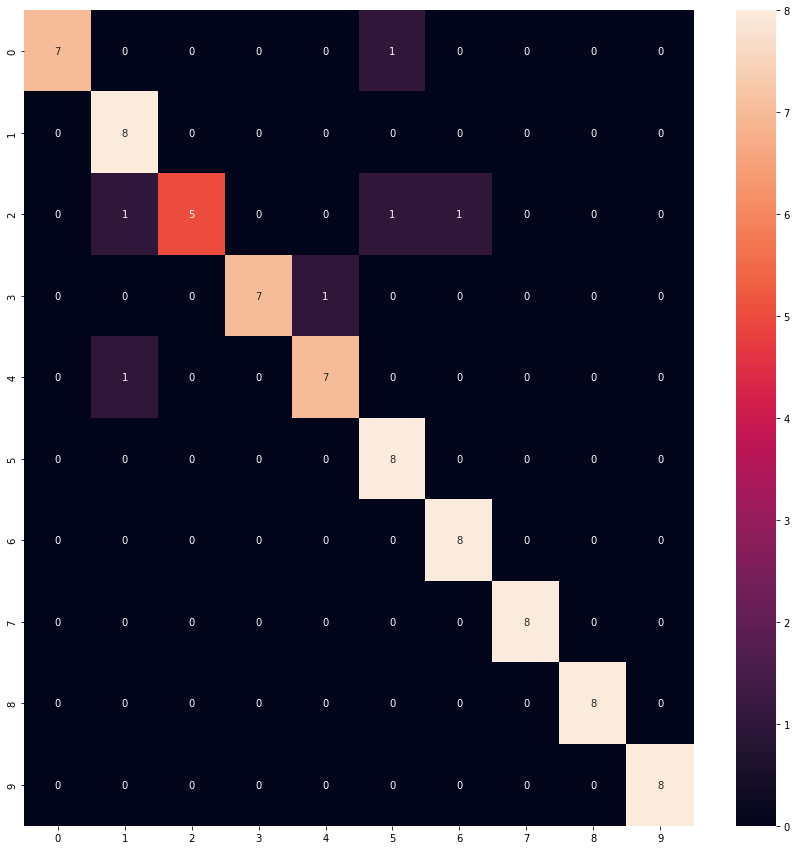

In [39]:
cn_matrix = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
plt.figure(figsize = (15,15))
sns.heatmap(cn_matrix, annot=True)